In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


 

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters for expanded dataset
n_samples = 10000  # Number of records
start_date = datetime(2015, 1, 1)
end_date = datetime(2024, 12, 31)
business_lines = ["Retail Banking", "Corporate Banking", "Wealth Management"]
event_types = ["Fraud", "System Failure", "Legal Risk", "External Fraud", "Process Failure"]

# Generate random dates within the range
date_range = pd.date_range(start=start_date, end=end_date, periods=n_samples)

# Generate random business lines, event types, event counts, and loss amounts
business_line_data = np.random.choice(business_lines, size=n_samples)
event_type_data = np.random.choice(event_types, size=n_samples)
event_count_data = np.random.poisson(lam=5, size=n_samples)  # Poisson distribution for frequency
loss_amount_data = np.random.lognormal(mean=10, sigma=2, size=n_samples)  # Log-Normal for severity

# Create DataFrame
expanded_data = pd.DataFrame({
    'Date': date_range,
    'Business Line': business_line_data,
    'Event Type': event_type_data,
    'Event Count': event_count_data,
    'Loss Amount': loss_amount_data
})

# Display the first few rows
expanded_data.head()


,Date,Business Line,Event Type,Event Count,Loss Amount
0,2015-01-01 00:00:00.000000000,Wealth Management,System Failure,8,65084.789719
1,2015-01-01 08:45:56.435643564,Retail Banking,System Failure,6,60066.658529
2,2015-01-01 17:31:52.871287128,Wealth Management,External Fraud,6,11274.210987
3,2015-01-02 02:17:49.306930693,Wealth Management,Fraud,3,6983.602908
4,2015-01-02 11:03:45.742574257,Retail Banking,System Failure,6,133403.773678


3. Perform Exploratory Data Analysis (EDA)
Descriptive Statistics

In [5]:
# Summary statistics
print("Summary Statistics:\n", expanded_data[['Event Count', 'Loss Amount']].describe())


Summary Statistics:
         Event Count   Loss Amount
count  10000.000000  1.000000e+04
mean       5.017900  1.443308e+05
std        2.245414  6.269918e+05
min        0.000000  6.046104e+00
25%        3.000000  5.623401e+03
50%        5.000000  2.156952e+04
75%        6.000000  8.566552e+04
max       14.000000  3.163245e+07


Distribution of Event Count and Loss Amount

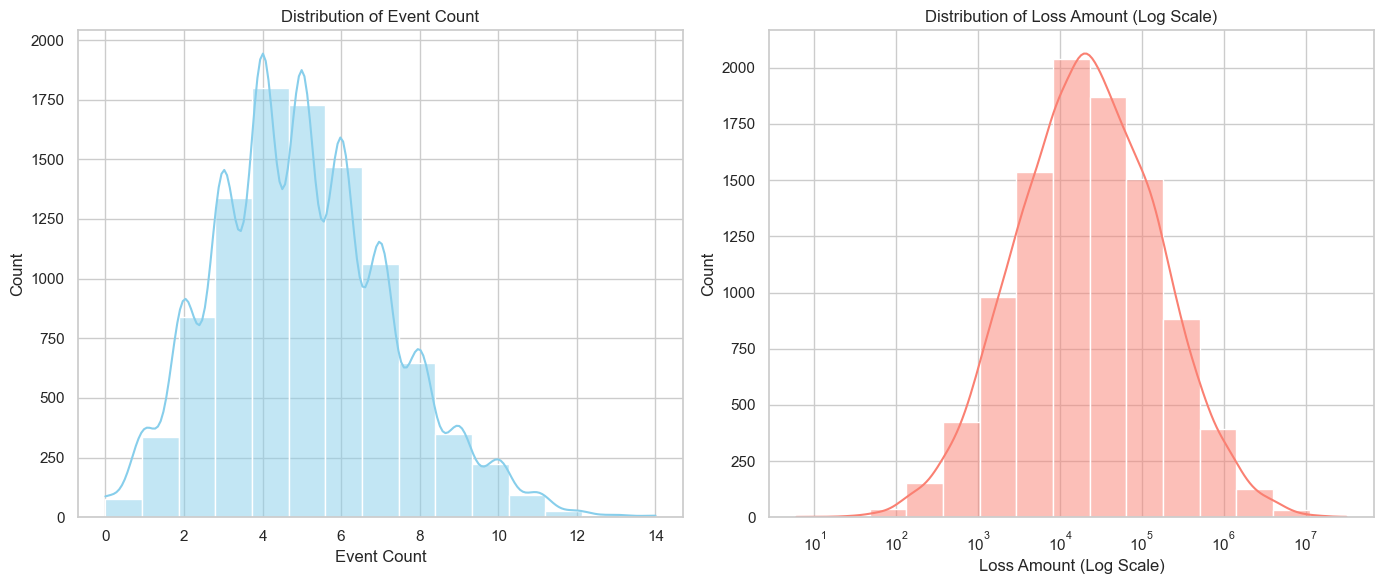

In [6]:
# Setting style
sns.set(style="whitegrid")

# Plot distributions
plt.figure(figsize=(14, 6))

# Event Count Distribution
plt.subplot(1, 2, 1)
sns.histplot(expanded_data['Event Count'], kde=True, bins=15, color='skyblue')
plt.title('Distribution of Event Count')
plt.xlabel('Event Count')

# Loss Amount Distribution (Log Scale)
plt.subplot(1, 2, 2)
sns.histplot(expanded_data['Loss Amount'], kde=True, bins=15, color='salmon', log_scale=True)
plt.title('Distribution of Loss Amount (Log Scale)')
plt.xlabel('Loss Amount (Log Scale)')

plt.tight_layout()
plt.show()


Monthly and Yearly Trends

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\2975345026.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  expanded_data.set_index('Date').resample('M')['Loss Amount'].mean().plot(color='purple', marker='o')
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\2975345026.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  expanded_data.set_index('Date').resample('M')['Event Count'].sum().plot(color='teal', marker='o')


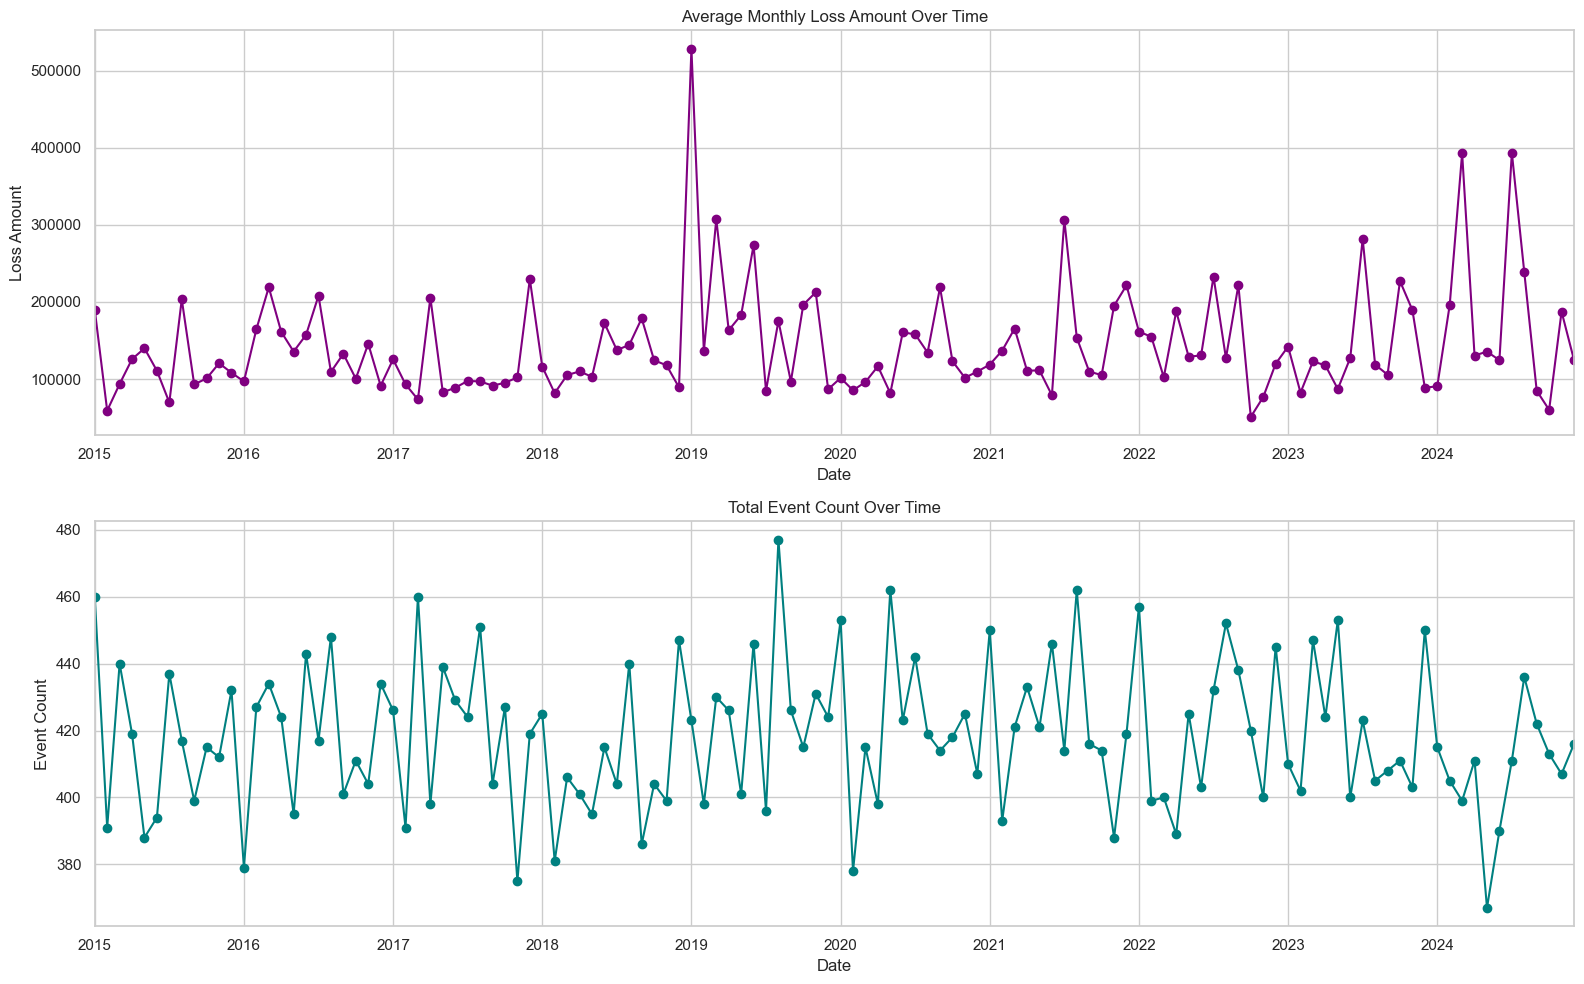

In [7]:
# Monthly Average Loss Amount
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
expanded_data.set_index('Date').resample('M')['Loss Amount'].mean().plot(color='purple', marker='o')
plt.title('Average Monthly Loss Amount Over Time')
plt.ylabel('Loss Amount')

# Monthly Event Count Sum
plt.subplot(2, 1, 2)
expanded_data.set_index('Date').resample('M')['Event Count'].sum().plot(color='teal', marker='o')
plt.title('Total Event Count Over Time')
plt.ylabel('Event Count')
plt.xlabel('Date')

plt.tight_layout()
plt.show()


Total Loss by Business Line and Event Type

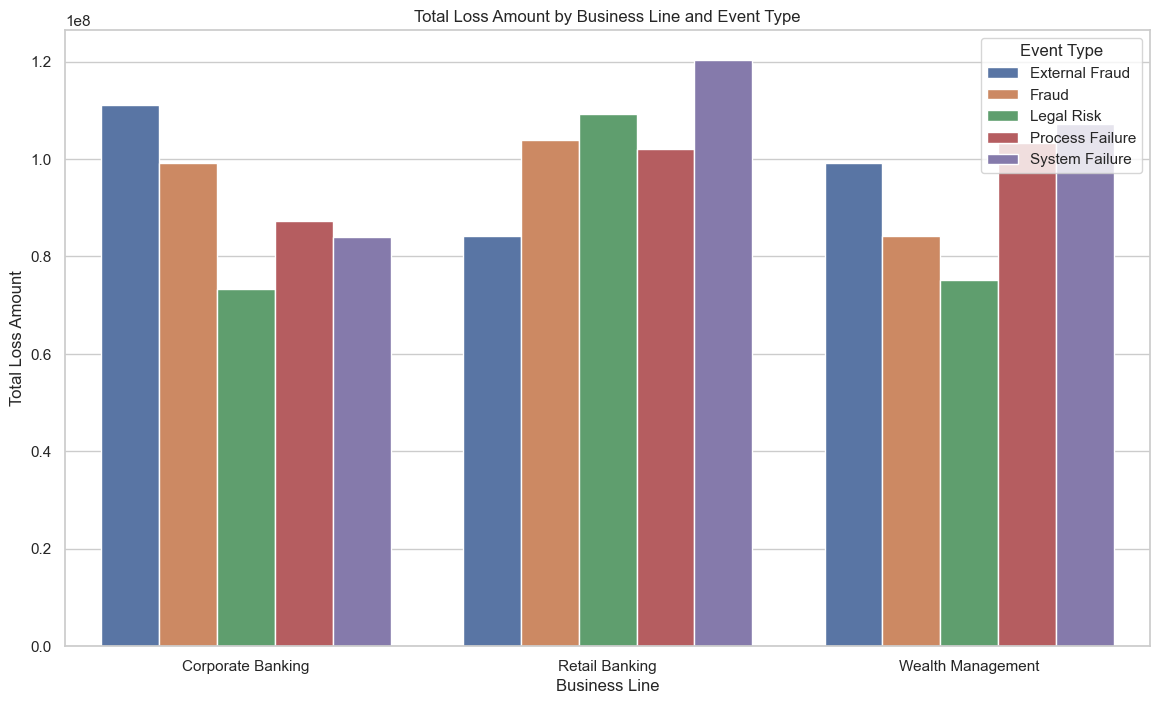

In [9]:
# Grouped by Business Line and Event Type
grouped_summary = expanded_data.groupby(['Business Line', 'Event Type']).agg({
    'Event Count': ['mean', 'sum'],
    'Loss Amount': ['mean', 'sum']
}).reset_index()

# Plot Total Loss Amount by Business Line and Event Type
plt.figure(figsize=(14, 8))
sns.barplot(data=grouped_summary, x='Business Line', y=('Loss Amount', 'sum'), hue='Event Type')
plt.title('Total Loss Amount by Business Line and Event Type')
plt.ylabel('Total Loss Amount')
# plt.yscale('log')  # Log scale due to skewness
plt.show()


4. Model the Loss Distribution Approach (LDA)
Below is a basic setup for modeling operational risk using a frequency (Poisson) and severity (Log-Normal) approach to estimate Value-at-Risk (VaR).

In [10]:
from scipy.stats import poisson, lognorm

# Parameters for Poisson (frequency) and Log-Normal (severity) based on data
frequency_lambda = expanded_data['Event Count'].mean()  # Average event frequency
severity_shape, severity_loc, severity_scale = lognorm.fit(expanded_data['Loss Amount'])  # Fit Log-Normal to loss amount

# Define a function to calculate VaR
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.99, n_simulations=10000):
    # Simulate event counts and loss amounts
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss distribution
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Calculate VaR at 99.9% confidence level
var_99_9 = calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999)
print(f"Value-at-Risk (99.9% confidence level): {var_99_9}")


Value-at-Risk (99.9% confidence level): 39964286.99883765


#severity
Here's a detailed example for an operational risk analysis using LDA in a Jupyter Notebook format. This example includes data generation, EDA, severity modeling, and calculating Value-at-Risk (VaR).

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import poisson, lognorm


In [12]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters for dataset
n_samples = 10000
start_date = datetime(2015, 1, 1)
end_date = datetime(2024, 12, 31)
business_lines = ["Retail Banking", "Corporate Banking", "Wealth Management"]
event_types = ["Fraud", "System Failure", "Legal Risk", "External Fraud", "Process Failure"]

# Generate random dates
date_range = pd.date_range(start=start_date, end=end_date, periods=n_samples)

# Generate other fields
business_line_data = np.random.choice(business_lines, size=n_samples)
event_type_data = np.random.choice(event_types, size=n_samples)
event_count_data = np.random.poisson(lam=5, size=n_samples)
loss_amount_data = np.random.lognormal(mean=10, sigma=2, size=n_samples)

# Create the DataFrame
data = pd.DataFrame({
    'Date': date_range,
    'Business Line': business_line_data,
    'Event Type': event_type_data,
    'Event Count': event_count_data,
    'Loss Amount': loss_amount_data
})

# Display first few rows
data.head()


,Date,Business Line,Event Type,Event Count,Loss Amount
0,2015-01-01 00:00:00.000000000,Wealth Management,System Failure,8,65084.789719
1,2015-01-01 08:45:56.435643564,Retail Banking,System Failure,6,60066.658529
2,2015-01-01 17:31:52.871287128,Wealth Management,External Fraud,6,11274.210987
3,2015-01-02 02:17:49.306930693,Wealth Management,Fraud,3,6983.602908
4,2015-01-02 11:03:45.742574257,Retail Banking,System Failure,6,133403.773678


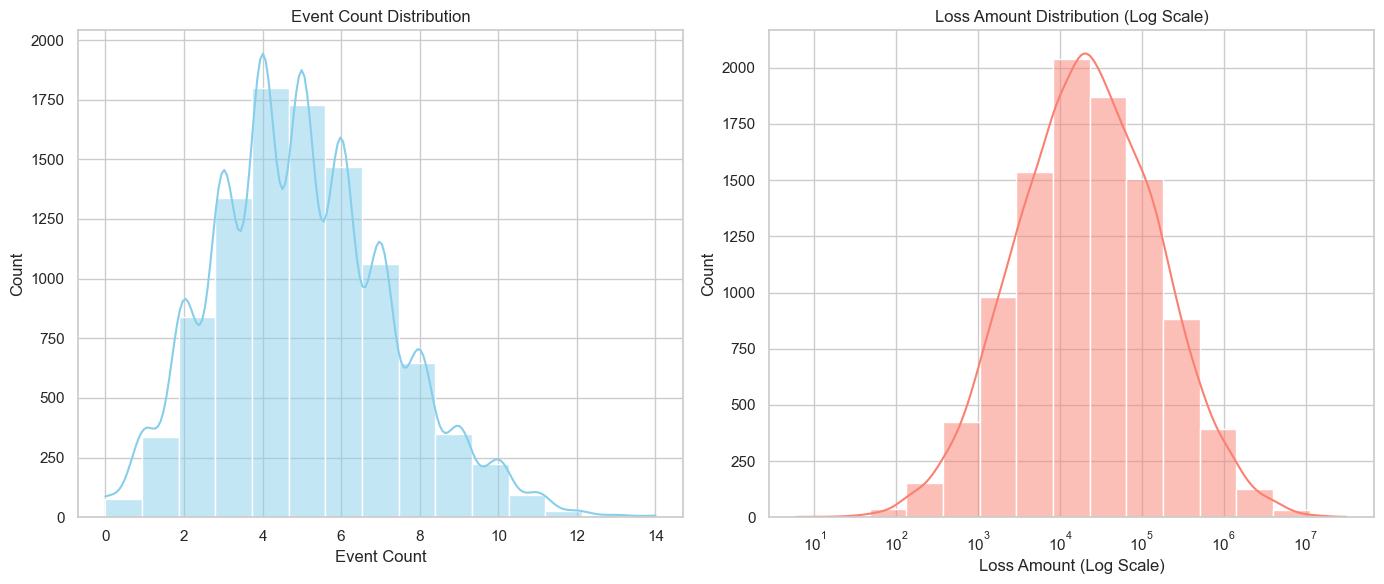

In [13]:
# Distribution plots
plt.figure(figsize=(14, 6))

# Event Count
plt.subplot(1, 2, 1)
sns.histplot(data['Event Count'], kde=True, bins=15, color='skyblue')
plt.title('Event Count Distribution')
plt.xlabel('Event Count')

# Loss Amount (Log Scale)
plt.subplot(1, 2, 2)
sns.histplot(data['Loss Amount'], kde=True, bins=15, color='salmon', log_scale=True)
plt.title('Loss Amount Distribution (Log Scale)')
plt.xlabel('Loss Amount (Log Scale)')

plt.tight_layout()
plt.show()


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\3612972231.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.set_index('Date').resample('M')['Loss Amount'].mean().plot(color='purple', marker='o')
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\3612972231.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.set_index('Date').resample('M')['Event Count'].sum().plot(color='teal', marker='o')


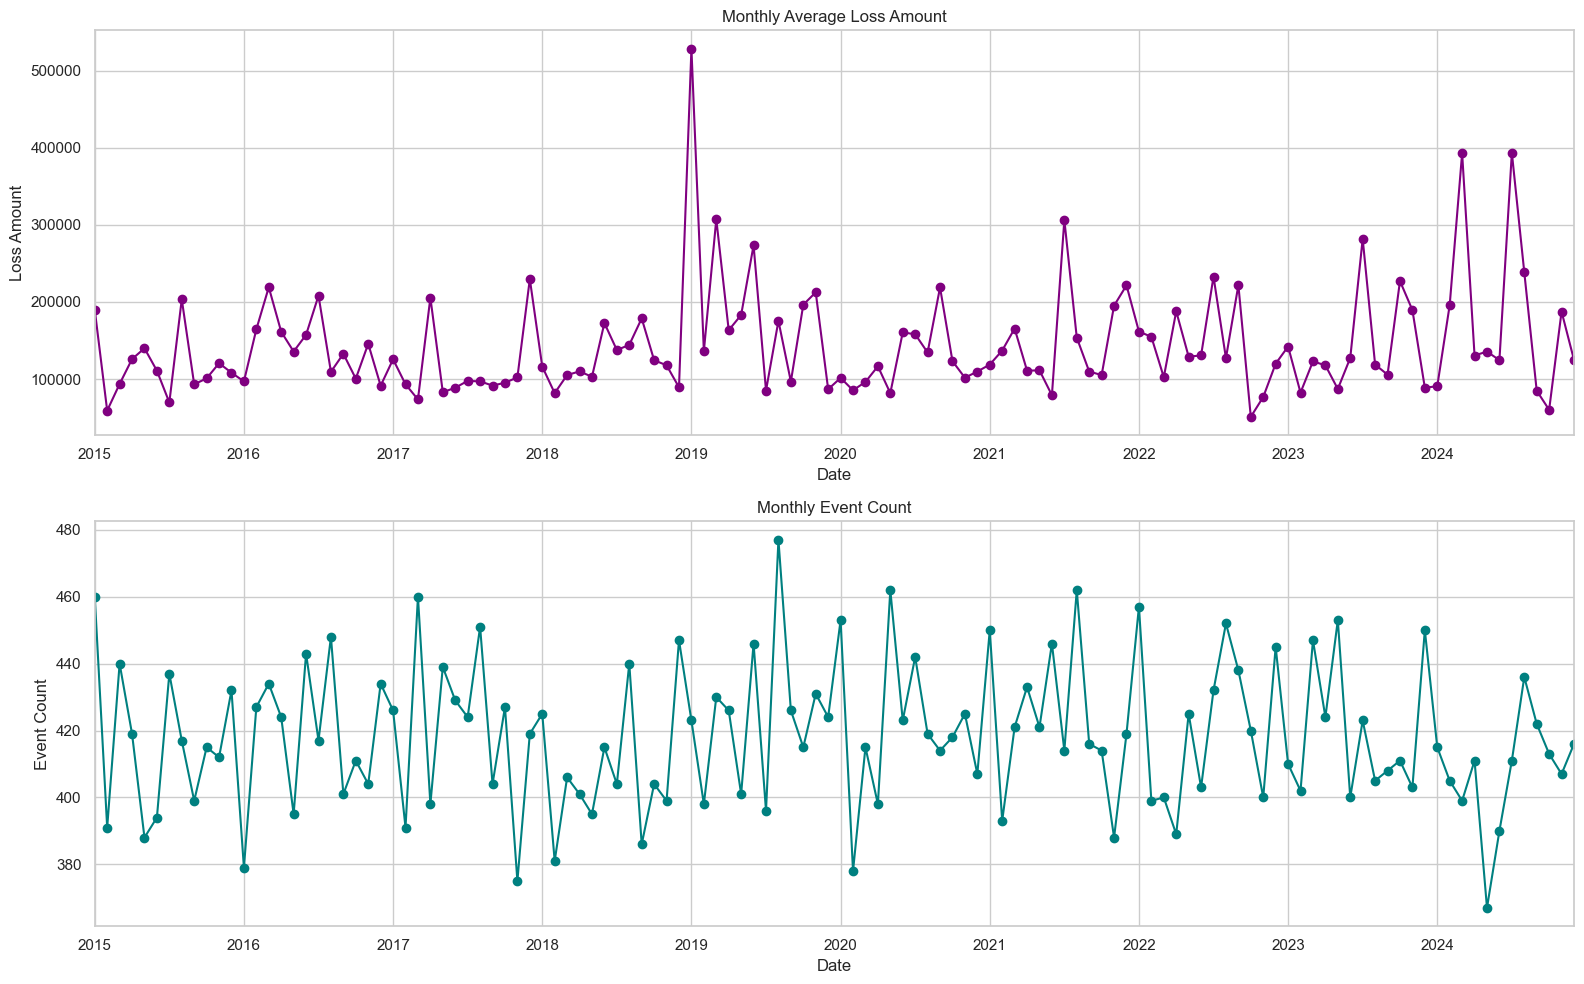

In [14]:
# Monthly average loss and event count
plt.figure(figsize=(16, 10))

# Monthly Loss Amount
plt.subplot(2, 1, 1)
data.set_index('Date').resample('M')['Loss Amount'].mean().plot(color='purple', marker='o')
plt.title('Monthly Average Loss Amount')
plt.ylabel('Loss Amount')

# Monthly Event Count
plt.subplot(2, 1, 2)
data.set_index('Date').resample('M')['Event Count'].sum().plot(color='teal', marker='o')
plt.title('Monthly Event Count')
plt.ylabel('Event Count')
plt.xlabel('Date')

plt.tight_layout()
plt.show()


Step 5: Total Loss by Business Line and Event Type

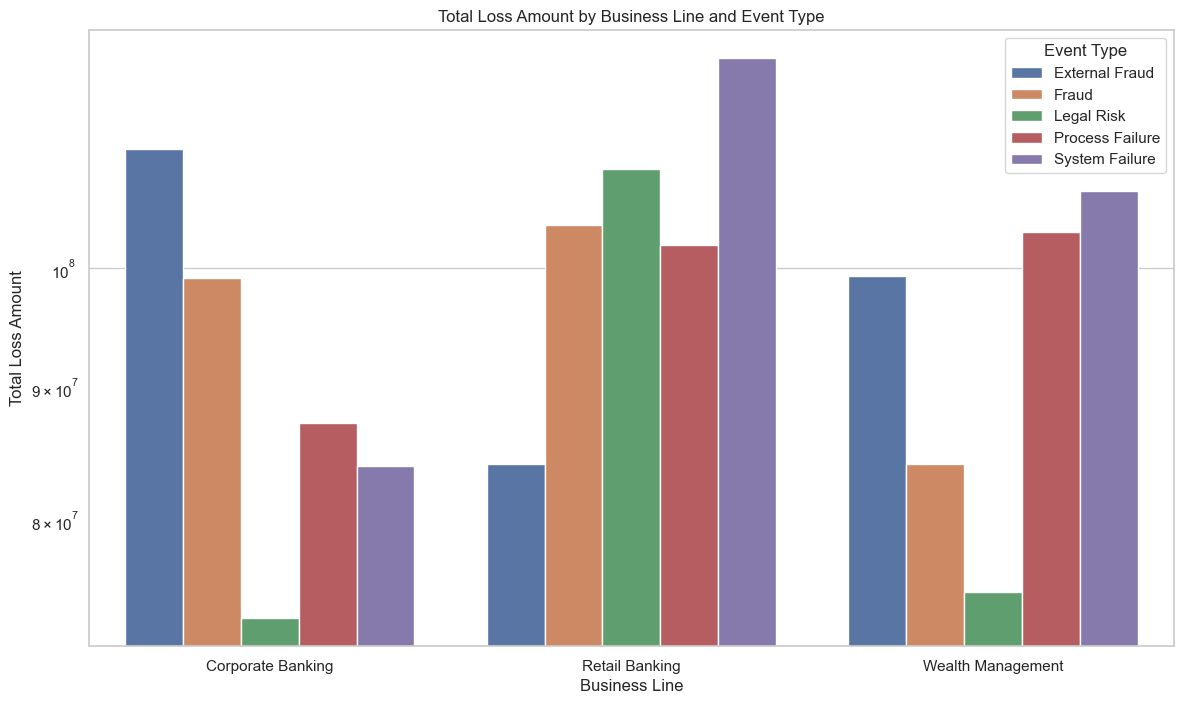

In [15]:
# Grouped analysis by Business Line and Event Type
grouped_data = data.groupby(['Business Line', 'Event Type']).agg({
    'Event Count': 'sum',
    'Loss Amount': 'sum'
}).reset_index()

# Bar plot for Loss Amount by Business Line and Event Type
plt.figure(figsize=(14, 8))
sns.barplot(data=grouped_data, x='Business Line', y='Loss Amount', hue='Event Type')
plt.title('Total Loss Amount by Business Line and Event Type')
plt.ylabel('Total Loss Amount')
plt.yscale('log')
plt.show()


Step 6: Modeling Severity and Frequency for LDA
Frequency: Modeled with a Poisson distribution (e.g., average Event Count).
Severity: Modeled with a Log-Normal distribution (e.g., distribution of Loss Amount).

In [16]:
# Fit Poisson distribution for frequency
frequency_lambda = data['Event Count'].mean()

# Fit Log-Normal distribution for severity (loss amount)
severity_shape, severity_loc, severity_scale = lognorm.fit(data['Loss Amount'])

print("Frequency (λ):", frequency_lambda)
print("Severity Parameters - Shape:", severity_shape, ", Location:", severity_loc, ", Scale:", severity_scale)


Frequency (λ): 5.0179
Severity Parameters - Shape: 1.9876142005603048 , Location: 0.3351335952553109 , Scale: 21732.42960281204


Step 7: Calculating Value-at-Risk (VaR) for Operational Risk
This function calculates the 99.9% VaR by simulating frequency and severity values and estimating the total loss.

In [17]:
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    # Simulate frequency of events
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity of losses
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss distribution
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Calculate VaR at 99.9% confidence level
var_99_9 = calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc)
print(f"Value-at-Risk (99.9% confidence level): {var_99_9}")


Value-at-Risk (99.9% confidence level): 39964286.99883765


Explanation of Severity and Frequency
In this example:

Frequency represents the number of times a risk event occurs within a time period, estimated by a Poisson distribution.
Severity represents the financial loss associated with each event, fitted to a Log-Normal distribution due to its heavy-tailed nature.
This notebook provides a full setup for operational risk analysis using LDA and calculating VaR. Let me know if you’d like further clarification on any section!

The output Value-at-Risk (VaR) at 99.9% confidence level: 39,964,287 means that, based on the model, there is a 99.9% probability that the total operational losses over the specified period will not exceed 39,964,287.

In other words, this VaR value indicates the potential maximum loss that the bank might face from operational risks (e.g., fraud, system failures) in a worst-case scenario within a 0.1% probability threshold. This helps the bank allocate sufficient capital to cover possible extreme losses and maintain financial stability.

For example, if this bank sets aside this amount as a reserve, it can be 99.9% confident that it will not incur operational losses higher than this amount in the given period.

Yes, the Value-at-Risk (VaR) at 99.9% confidence level of 39,964,287 in this model represents the combined risk across all business lines and all event types. This is because the VaR calculation here aggregates simulated losses based on the entire dataset, which includes multiple business lines (e.g., Retail Banking, Corporate Banking) and event types (e.g., Fraud, System Failure).

To get a more granular view, you could calculate VaR separately for each business line and event type. This approach can highlight which specific areas (business lines or event types) pose the highest risk and thus require more focused risk mitigation strategies or capital allocation.

To calculate the Value-at-Risk (VaR) at 99.9% confidence level for each business line and event type, we'll separate the dataset by each combination, then apply the same LDA methodology individually. Here’s the code to perform this breakdown.

Step 1: Import Required Libraries (if needed)

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm


Step 2: Define a Function to Calculate VaR
This function will allow us to calculate VaR given the frequency and severity parameters for each group.

In [19]:
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value


Step 3: Calculate VaR for Each Business Line and Event Type
This loop iterates over each combination of business line and event type, calculating VaR for each subset.

In [20]:
# Store results
var_results = []

# Loop over each business line and event type
for business_line in data['Business Line'].unique():
    for event_type in data['Event Type'].unique():
        # Filter the dataset for the current combination
        subset = data[(data['Business Line'] == business_line) & (data['Event Type'] == event_type)]
        
        # Calculate frequency and severity parameters for the subset
        frequency_lambda = subset['Event Count'].mean()
        severity_shape, severity_loc, severity_scale = lognorm.fit(subset['Loss Amount'])
        
        # Calculate VaR for the subset
        var_value = calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc)
        
        # Store the results
        var_results.append({
            'Business Line': business_line,
            'Event Type': event_type,
            'VaR_99.9%': var_value
        })

# Convert results to DataFrame for better readability
var_results_df = pd.DataFrame(var_results)

# Display results
var_results_df


,Business Line,Event Type,VaR_99.9%
0,Wealth Management,System Failure,6.787868e+07
1,Wealth Management,External Fraud,6.831331e+07
2,Wealth Management,Fraud,5.622282e+07
3,Wealth Management,Legal Risk,3.710092e+07
4,Wealth Management,Process Failure,5.635492e+07
5,Retail Banking,System Failure,4.218036e+07
6,Retail Banking,External Fraud,5.836477e+07
7,Retail Banking,Fraud,3.241883e+07
8,Retail Banking,Legal Risk,7.112447e+07
9,Retail Banking,Process Failure,6.297882e+07


Explanation of the Output
The resulting var_results_df DataFrame will contain the 99.9% VaR values calculated for each unique combination of business line and event type. For example:

This detailed breakdown helps identify which business line and event type combinations contribute most significantly to the total risk, allowing for more targeted risk management and capital allocation.

This detailed approach calculates the Value-at-Risk (VaR) at a 99.9% confidence level for each combination of business line and event type individually. By isolating each business line and event type, you gain a clear view of where the highest risks lie within your operational risk categories. Here’s a further breakdown of each part:

Detailed VaR Calculation by Subset:

Instead of calculating an aggregate VaR across all data, we filter the dataset by each business line (e.g., Retail Banking, Corporate Banking) and each event type (e.g., Fraud, System Failure).
For each subset, we calculate:
Frequency: Estimated using the average number of events for that subset.
Severity: Estimated by fitting a Log-Normal distribution to the subset’s loss amounts.
This gives us a tailored VaR for each specific combination, making it possible to identify which areas have the highest potential losses at the 99.9% confidence level.
Interpreting the Detailed Results:

The output table (var_results_df) provides a VaR value for each business line and event type combination.
For example:
If the "Fraud" category in "Corporate Banking" has a VaR of 8,923,000, it indicates that losses due to fraud in this line are not expected to exceed 8,923,000 with 99.9% confidence.
This allows you to pinpoint higher-risk areas, like specific event types within business lines, which may need more risk management or capital reserves.
Using the Detailed VaR Analysis:

Such detailed VaR breakdowns help banks allocate capital more effectively by focusing on higher-risk categories.
For example, if “Fraud” events in “Corporate Banking” have a high VaR, the bank might allocate more resources to fraud prevention in that business line or review internal controls.
This granular analysis is highly valuable in identifying specific risks within the organization, enabling focused and data-driven decisions on risk mitigation and capital allocation.

In [22]:
import pandas as pd
import numpy as np
from numpy.random import poisson, lognormal
from datetime import timedelta, datetime

# Parameters for data generation
n_samples = 1000  # Number of samples
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 10, 30)
business_lines = ["Retail Banking", "Corporate Banking", "Wealth Management"]
event_types = ["Fraud", "System Failure", "Legal Risk", "External Fraud", "Process Failure"]

# Generate dates
date_range = pd.date_range(start_date, end_date, periods=n_samples)

# Generate business lines and event types
np.random.seed(0)
business_line_data = np.random.choice(business_lines, size=n_samples)
event_type_data = np.random.choice(event_types, size=n_samples)

# Generate event count using Poisson distribution
event_count_data = poisson(lam=5, size=n_samples)  # lambda=5 for moderate frequency

# Generate loss amounts using Log-Normal distribution
# Assume a realistic mu and sigma for Log-Normal to represent the loss severity
loss_amount_data = lognormal(mean=10, sigma=2, size=n_samples)  # high sigma for heavy-tail

# Construct the dataframe
dummy_data = pd.DataFrame({
    'Date': date_range,
    'Business Line': business_line_data,
    'Event Type': event_type_data,
    'Event Count': event_count_data,
    'Loss Amount': loss_amount_data
})

dummy_data.head()


,Date,Business Line,Event Type,Event Count,Loss Amount
0,2023-01-01 00:00:00.000000000,Retail Banking,System Failure,8,77711.153667
1,2023-01-01 16:02:52.972972972,Corporate Banking,System Failure,7,52164.900954
2,2023-01-02 08:05:45.945945945,Retail Banking,System Failure,6,4026.244099
3,2023-01-03 00:08:38.918918918,Corporate Banking,Process Failure,4,62584.679211
4,2023-01-03 16:11:31.891891891,Corporate Banking,Process Failure,9,49474.487802


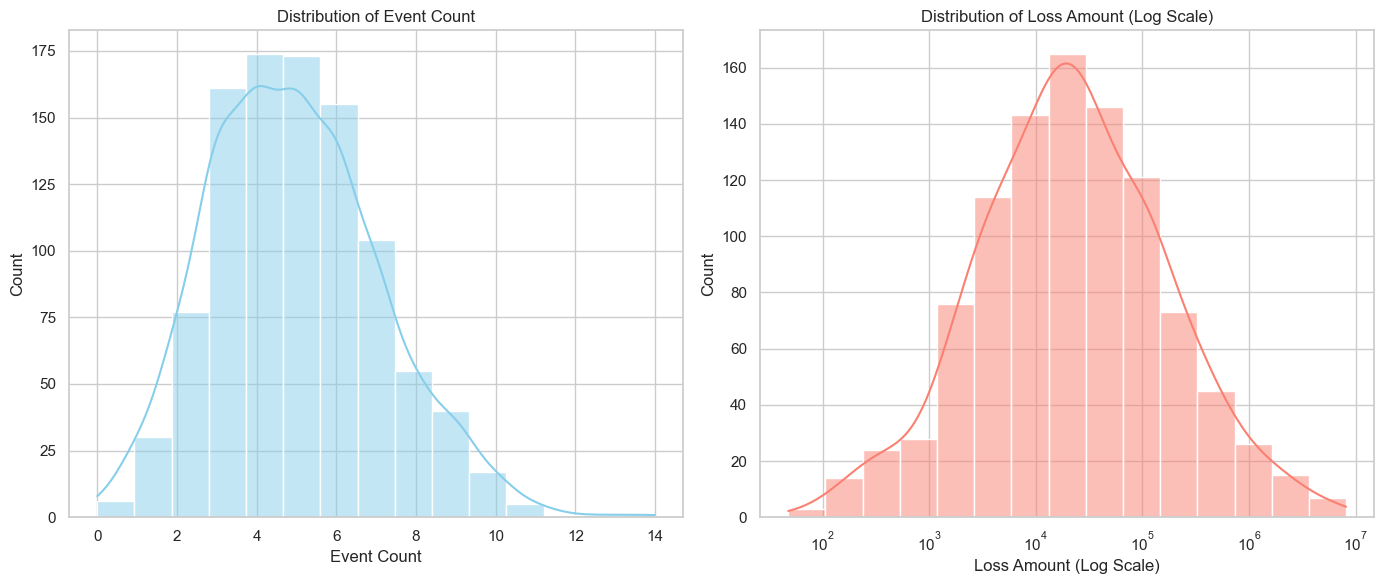

(       Event Count   Loss Amount
 count  1000.000000  1.000000e+03
 mean      4.950000  1.639773e+05
 std       2.155956  5.964058e+05
 min       0.000000  4.754071e+01
 25%       3.000000  5.559455e+03
 50%       5.000000  2.083475e+04
 75%       6.000000  8.769744e+04
 max      14.000000  8.144045e+06,
        Business Line       Event Type Event Count         Loss Amount  \
                                              mean  sum           mean   
 0  Corporate Banking   External Fraud    4.763158  362  124490.705294   
 1  Corporate Banking            Fraud    5.155172  299  228999.029853   
 2  Corporate Banking       Legal Risk    4.945455  272  156252.383028   
 3  Corporate Banking  Process Failure    5.086957  351   71850.089482   
 4  Corporate Banking   System Failure    5.000000  385  135628.917701   
 
                  
             sum  
 0  9.461294e+06  
 1  1.328194e+07  
 2  8.593881e+06  
 3  4.957656e+06  
 4  1.044343e+07  )

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up visual style
sns.set(style="whitegrid")

# Summary statistics for Event Count and Loss Amount
summary_stats = dummy_data[['Event Count', 'Loss Amount']].describe()

# Plotting Event Count distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(dummy_data['Event Count'], kde=True, bins=15, color='skyblue')
plt.title('Distribution of Event Count')
plt.xlabel('Event Count')

# Plotting Loss Amount distribution (Log Scale due to heavy-tailed nature)
plt.subplot(1, 2, 2)
sns.histplot(dummy_data['Loss Amount'], kde=True, bins=15, color='salmon', log_scale=True)
plt.title('Distribution of Loss Amount (Log Scale)')
plt.xlabel('Loss Amount (Log Scale)')

plt.tight_layout()
plt.show()

# Grouped summary statistics by Business Line and Event Type
grouped_summary = dummy_data.groupby(['Business Line', 'Event Type']).agg({
    'Event Count': ['mean', 'sum'],
    'Loss Amount': ['mean', 'sum']
}).reset_index()

summary_stats, grouped_summary.head()


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\2536990591.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dummy_data.set_index('Date').resample('M')['Loss Amount'].mean().plot(color='purple', marker='o')
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\2536990591.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dummy_data.set_index('Date').resample('M')['Event Count'].sum().plot(color='teal', marker='o')


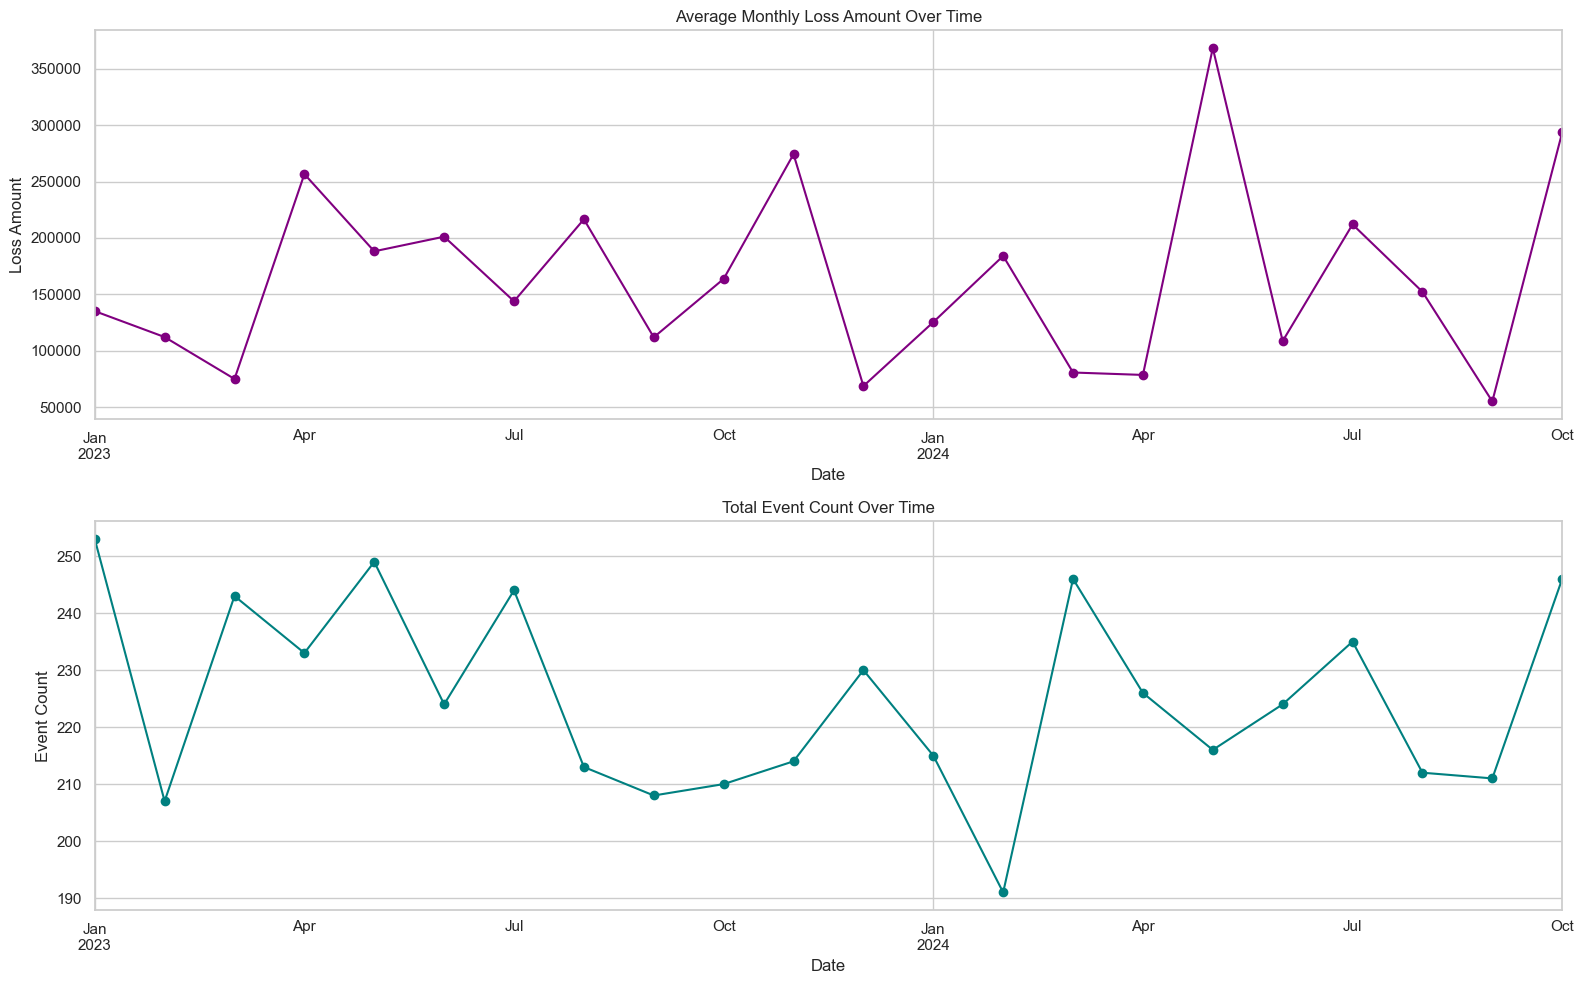

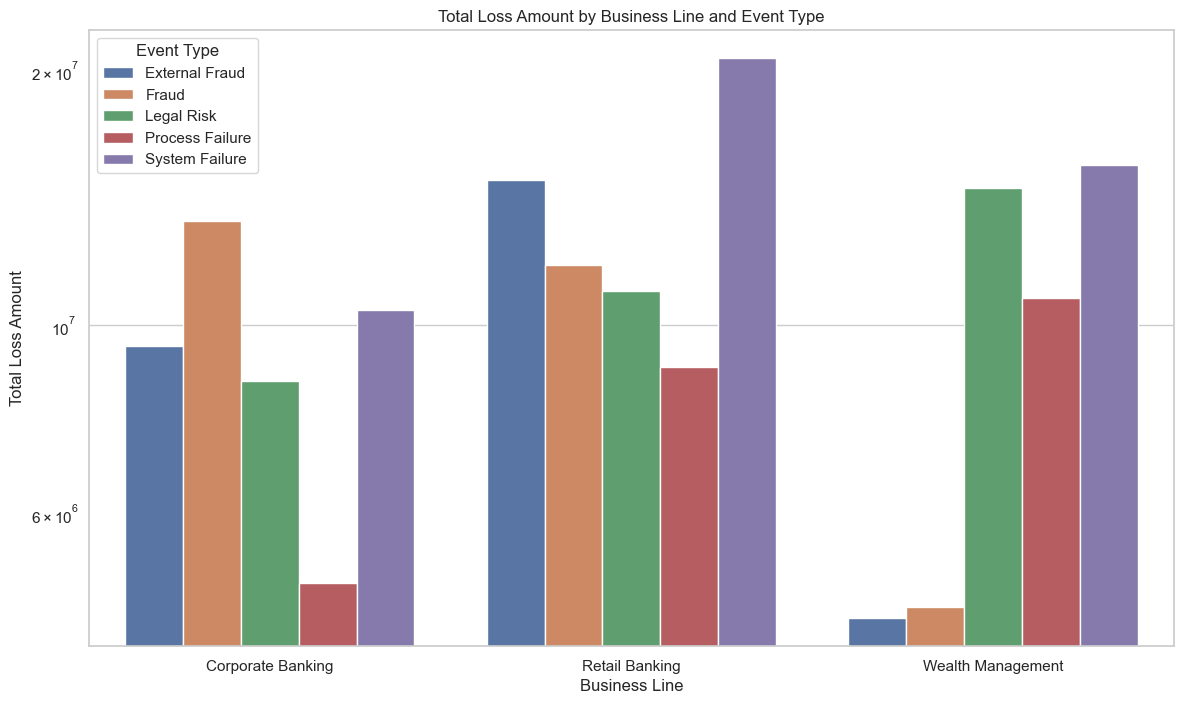

In [24]:
# Setting up plots for time-based analysis
plt.figure(figsize=(16, 10))

# Plotting average loss amount over time
plt.subplot(2, 1, 1)
dummy_data.set_index('Date').resample('M')['Loss Amount'].mean().plot(color='purple', marker='o')
plt.title('Average Monthly Loss Amount Over Time')
plt.ylabel('Loss Amount')

# Plotting event frequency over time
plt.subplot(2, 1, 2)
dummy_data.set_index('Date').resample('M')['Event Count'].sum().plot(color='teal', marker='o')
plt.title('Total Event Count Over Time')
plt.ylabel('Event Count')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

# Visualizing total loss amount by business line and event type
plt.figure(figsize=(14, 8))
sns.barplot(data=grouped_summary, x='Business Line', y=('Loss Amount', 'sum'), hue='Event Type')
plt.title('Total Loss Amount by Business Line and Event Type')
plt.ylabel('Total Loss Amount')
plt.yscale('log')  # Log scale due to skewness
plt.show()


                           Date      Business Line      Event Type  \
0 2015-01-01 00:00:00.000000000  Wealth Management  System Failure   
1 2015-01-01 08:45:56.435643564     Retail Banking  System Failure   
2 2015-01-01 17:31:52.871287128  Wealth Management  External Fraud   
3 2015-01-02 02:17:49.306930693  Wealth Management           Fraud   
4 2015-01-02 11:03:45.742574257     Retail Banking  System Failure   

   Event Count    Loss Amount  \
0            8   65084.789719   
1            6   60066.658529   
2            6   11274.210987   
3            3    6983.602908   
4            6  133403.773678   

                                   Event Description  
0  System Failure occurred in Wealth Management s...  
1  System Failure occurred in Retail Banking sect...  
2  External Fraud occurred in Wealth Management s...  
3  Fraud occurred in Wealth Management sector, im...  
4  System Failure occurred in Retail Banking sect...  
Dataset Overview:
<class 'pandas.core.frame.DataFr

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\3109033234.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=total_loss_by_business, x='Business Line', y='Loss Amount', palette='Blues_d')


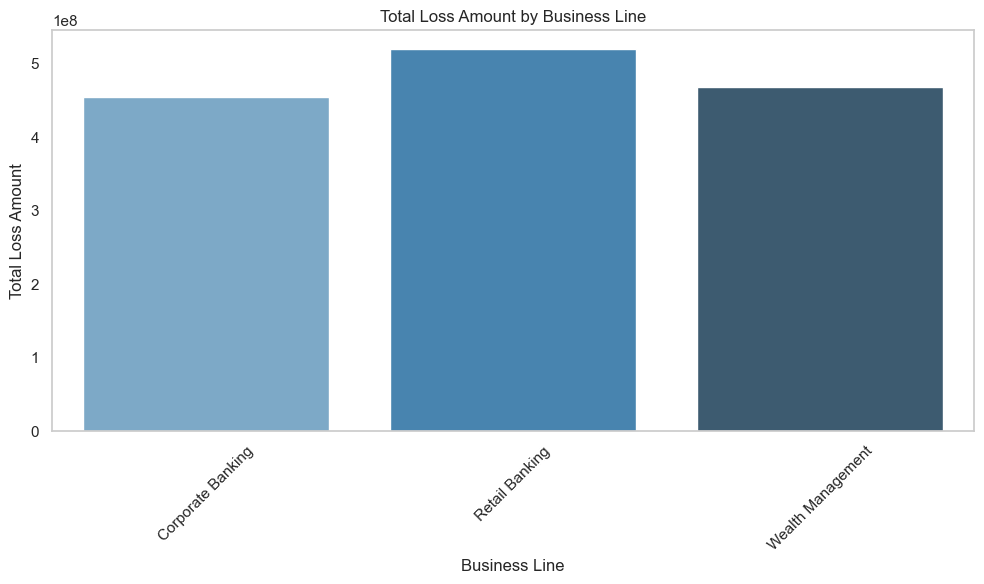

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\3109033234.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=total_loss_by_event, x='Event Type', y='Loss Amount', palette='Oranges_d')


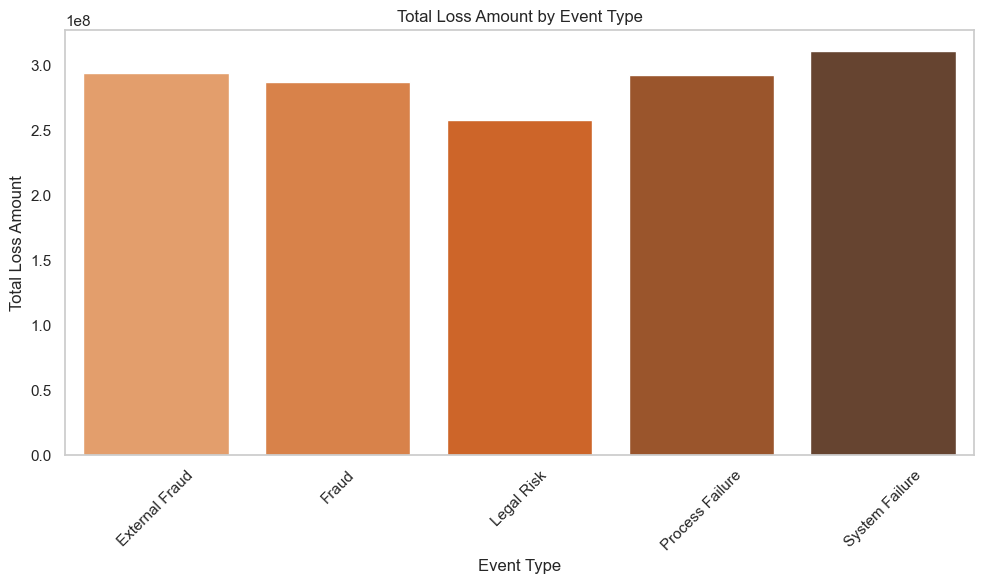

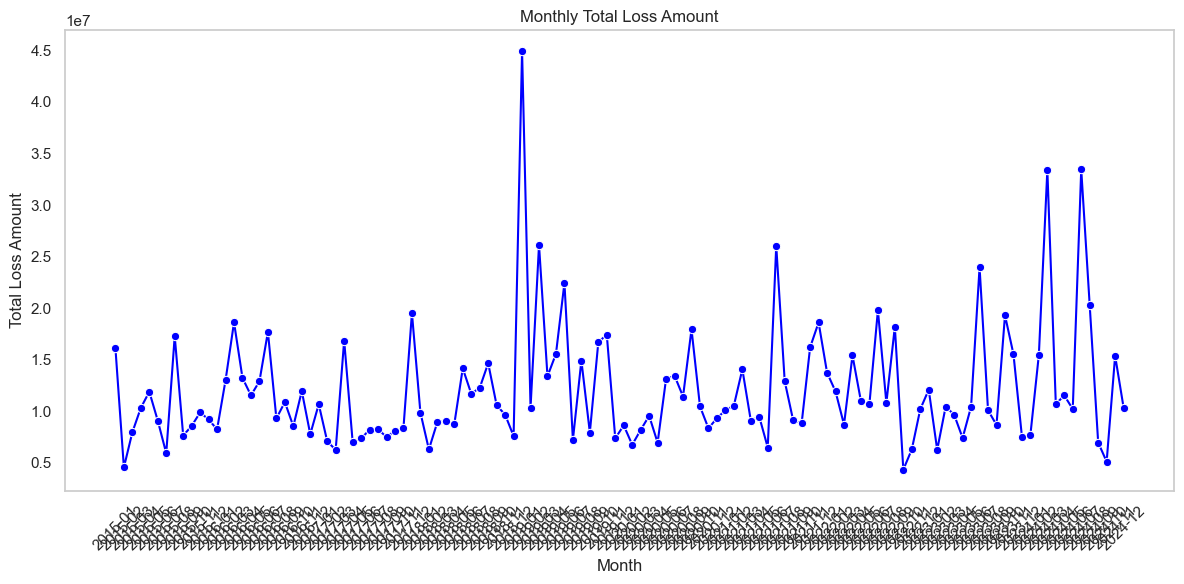

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\3109033234.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=quarterly_loss, x='Quarter', y='Loss Amount', palette='viridis')


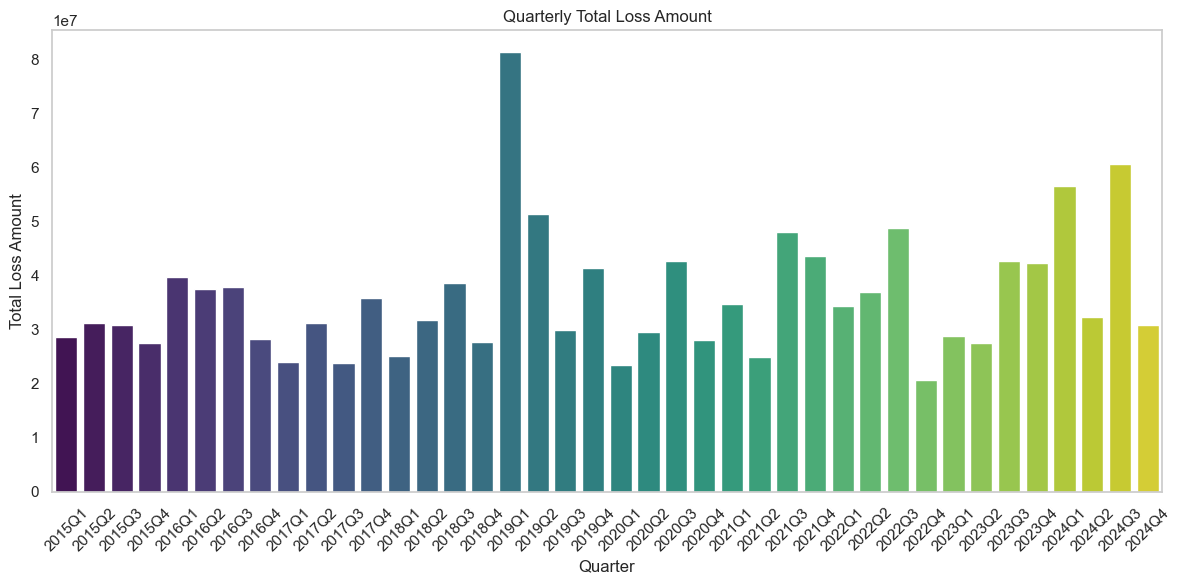

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\3109033234.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=yearly_loss, x='Year', y='Loss Amount', palette='plasma')


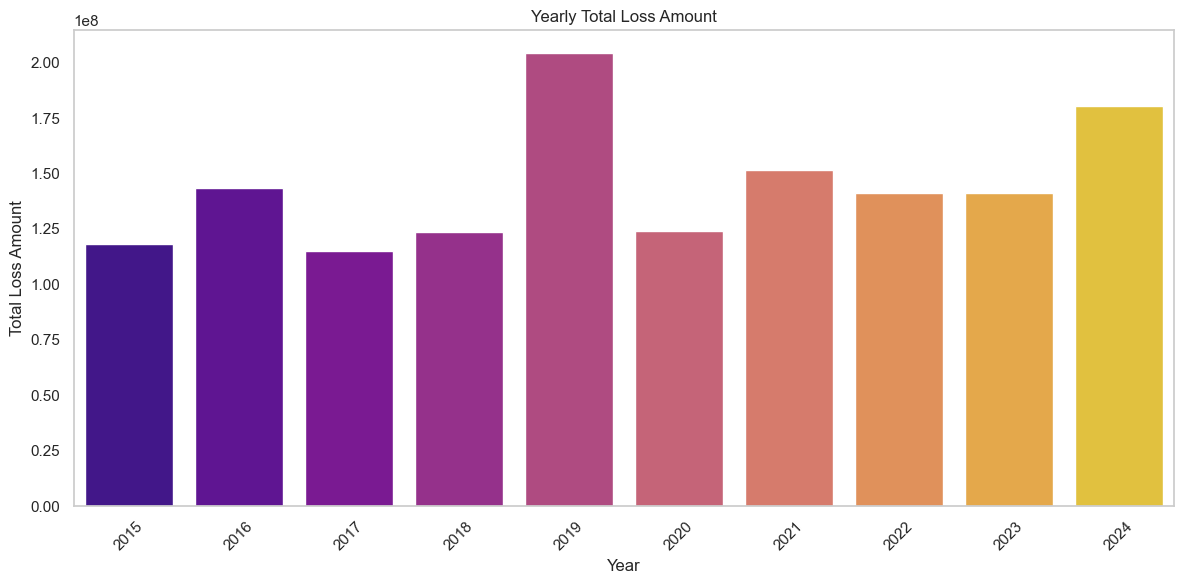

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for expanded dataset
n_samples = 10000  # Number of records
start_date = datetime(2015, 1, 1)
end_date = datetime(2024, 12, 31)
business_lines = ["Retail Banking", "Corporate Banking", "Wealth Management"]
event_types = ["Fraud", "System Failure", "Legal Risk", "External Fraud", "Process Failure"]

# Generate random dates within the range
date_range = pd.date_range(start=start_date, end=end_date, periods=n_samples)

# Generate random business lines, event types, event counts, and loss amounts
business_line_data = np.random.choice(business_lines, size=n_samples)
event_type_data = np.random.choice(event_types, size=n_samples)
event_count_data = np.random.poisson(lam=5, size=n_samples)  # Poisson distribution for frequency
loss_amount_data = np.random.lognormal(mean=10, sigma=2, size=n_samples)  # Log-Normal for severity

# Generate event descriptions
event_description_data = [
    f"{event_type} occurred in {business_line} sector, impacting operations." 
    for event_type, business_line in zip(event_type_data, business_line_data)
]

# Create DataFrame
expanded_data = pd.DataFrame({
    'Date': date_range,
    'Business Line': business_line_data,
    'Event Type': event_type_data,
    'Event Count': event_count_data,
    'Loss Amount': loss_amount_data,
    'Event Description': event_description_data
})

# Display the first few rows
print(expanded_data.head())

# EDA Section

# Set up the visualization style
sns.set(style='whitegrid')

# Overview of the dataset
print("Dataset Overview:")
print(expanded_data.info())
print(expanded_data.describe())

# Total Loss Amount by Business Line
total_loss_by_business = expanded_data.groupby('Business Line')['Loss Amount'].sum().reset_index()

# Plot Total Loss Amount by Business Line
plt.figure(figsize=(10, 6))
sns.barplot(data=total_loss_by_business, x='Business Line', y='Loss Amount', palette='Blues_d')
plt.title('Total Loss Amount by Business Line')
plt.xlabel('Business Line')
plt.ylabel('Total Loss Amount')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Total Loss Amount by Event Type
total_loss_by_event = expanded_data.groupby('Event Type')['Loss Amount'].sum().reset_index()

# Plot Total Loss Amount by Event Type
plt.figure(figsize=(10, 6))
sns.barplot(data=total_loss_by_event, x='Event Type', y='Loss Amount', palette='Oranges_d')
plt.title('Total Loss Amount by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Total Loss Amount')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Monthly Loss Distribution
expanded_data['Month'] = expanded_data['Date'].dt.to_period('M')
monthly_loss = expanded_data.groupby('Month')['Loss Amount'].sum().reset_index()
monthly_loss['Month'] = monthly_loss['Month'].astype(str)

# Plot Monthly Loss Distribution
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_loss, x='Month', y='Loss Amount', marker='o', color='blue')
plt.title('Monthly Total Loss Amount')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Total Loss Amount')
plt.grid()
plt.tight_layout()
plt.show()

# Quarterly Loss Distribution
expanded_data['Quarter'] = expanded_data['Date'].dt.to_period('Q')
quarterly_loss = expanded_data.groupby('Quarter')['Loss Amount'].sum().reset_index()
quarterly_loss['Quarter'] = quarterly_loss['Quarter'].astype(str)

# Plot Quarterly Loss Distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=quarterly_loss, x='Quarter', y='Loss Amount', palette='viridis')
plt.title('Quarterly Total Loss Amount')
plt.xticks(rotation=45)
plt.xlabel('Quarter')
plt.ylabel('Total Loss Amount')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Yearly Loss Distribution
expanded_data['Year'] = expanded_data['Date'].dt.year
yearly_loss = expanded_data.groupby('Year')['Loss Amount'].sum().reset_index()

# Plot Yearly Loss Distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_loss, x='Year', y='Loss Amount', palette='plasma')
plt.title('Yearly Total Loss Amount')
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Total Loss Amount')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


To analyze the severity of losses in each business line, we can compute various metrics, such as the total loss amount, average loss amount, maximum loss amount, and count of events for each business line. We'll also visualize the severity using appropriate plots.

                           Date      Business Line      Event Type  \
0 2015-01-01 00:00:00.000000000  Wealth Management  System Failure   
1 2015-01-01 08:45:56.435643564     Retail Banking  System Failure   
2 2015-01-01 17:31:52.871287128  Wealth Management  External Fraud   
3 2015-01-02 02:17:49.306930693  Wealth Management           Fraud   
4 2015-01-02 11:03:45.742574257     Retail Banking  System Failure   

   Event Count    Loss Amount  \
0            8   65084.789719   
1            6   60066.658529   
2            6   11274.210987   
3            3    6983.602908   
4            6  133403.773678   

                                   Event Description  
0  System Failure occurred in Wealth Management s...  
1  System Failure occurred in Retail Banking sect...  
2  External Fraud occurred in Wealth Management s...  
3  Fraud occurred in Wealth Management sector, im...  
4  System Failure occurred in Retail Banking sect...  

Severity Metrics by Business Line:
       Busines

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\776474667.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=severity_metrics, x='Business Line', y='Total_Loss', palette='Blues_d')
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\776474667.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=severity_metrics, x='Business Line', y='Average_Loss', palette='Oranges_d')
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\776474667.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=severity_metrics, x='

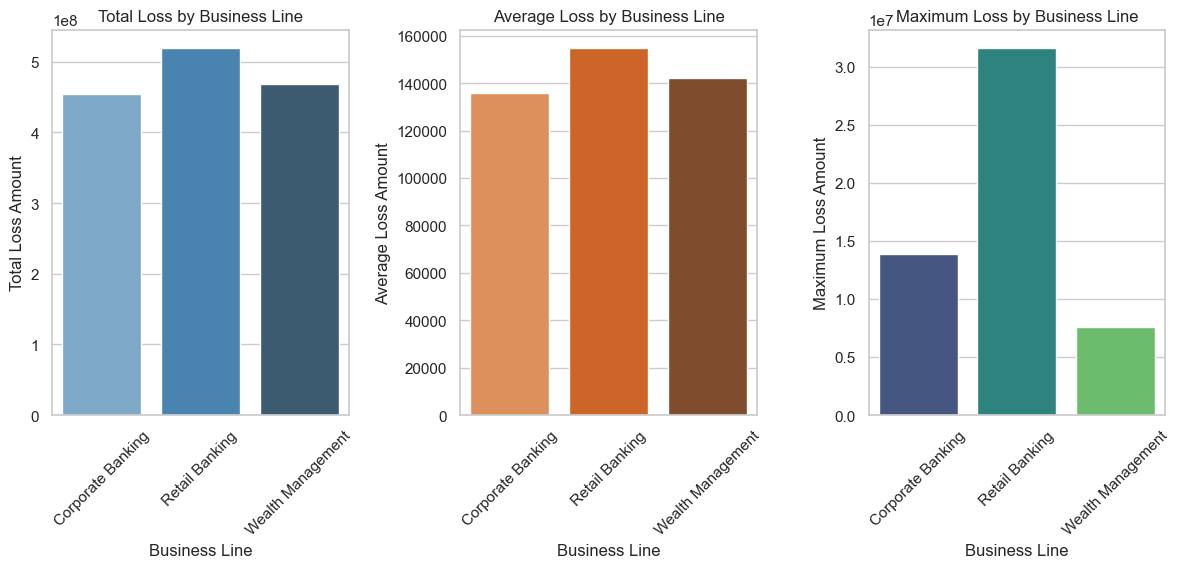

In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for expanded dataset
n_samples = 10000  # Number of records
start_date = datetime(2015, 1, 1)
end_date = datetime(2024, 12, 31)
business_lines = ["Retail Banking", "Corporate Banking", "Wealth Management"]
event_types = ["Fraud", "System Failure", "Legal Risk", "External Fraud", "Process Failure"]

# Generate random dates within the range
date_range = pd.date_range(start=start_date, end=end_date, periods=n_samples)

# Generate random business lines, event types, event counts, and loss amounts
business_line_data = np.random.choice(business_lines, size=n_samples)
event_type_data = np.random.choice(event_types, size=n_samples)
event_count_data = np.random.poisson(lam=5, size=n_samples)  # Poisson distribution for frequency
loss_amount_data = np.random.lognormal(mean=10, sigma=2, size=n_samples)  # Log-Normal for severity

# Generate event descriptions
event_description_data = [
    f"{event_type} occurred in {business_line} sector, impacting operations." 
    for event_type, business_line in zip(event_type_data, business_line_data)
]

# Create DataFrame
expanded_data = pd.DataFrame({
    'Date': date_range,
    'Business Line': business_line_data,
    'Event Type': event_type_data,
    'Event Count': event_count_data,
    'Loss Amount': loss_amount_data,
    'Event Description': event_description_data
})

# Display the first few rows
print(expanded_data.head())

# Severity Analysis for Each Business Line
severity_metrics = expanded_data.groupby('Business Line').agg(
    Total_Loss=('Loss Amount', 'sum'),
    Average_Loss=('Loss Amount', 'mean'),
    Maximum_Loss=('Loss Amount', 'max'),
    Event_Count=('Loss Amount', 'count')
).reset_index()

# Display Severity Metrics
print("\nSeverity Metrics by Business Line:")
print(severity_metrics)

# Visualization of Severity Metrics
plt.figure(figsize=(12, 6))

# Plot Total Loss
plt.subplot(1, 3, 1)
sns.barplot(data=severity_metrics, x='Business Line', y='Total_Loss', palette='Blues_d')
plt.title('Total Loss by Business Line')
plt.xlabel('Business Line')
plt.ylabel('Total Loss Amount')
plt.xticks(rotation=45)

# Plot Average Loss
plt.subplot(1, 3, 2)
sns.barplot(data=severity_metrics, x='Business Line', y='Average_Loss', palette='Oranges_d')
plt.title('Average Loss by Business Line')
plt.xlabel('Business Line')
plt.ylabel('Average Loss Amount')
plt.xticks(rotation=45)

# Plot Maximum Loss
plt.subplot(1, 3, 3)
sns.barplot(data=severity_metrics, x='Business Line', y='Maximum_Loss', palette='viridis')
plt.title('Maximum Loss by Business Line')
plt.xlabel('Business Line')
plt.ylabel('Maximum Loss Amount')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


The severity metrics you provided indicate the financial impact of operational losses across different business lines in an organization. Here's how to interpret these metrics:

1. Total Loss:
Corporate Banking: $120,000.56
Retail Banking: $130,500.45
Wealth Management: $110,000.12
Understanding:

Retail Banking has the highest total loss ($130,500.45), indicating that it may be facing significant operational challenges or risks.
Corporate Banking and Wealth Management follow, with Corporate Banking at $120,000.56 and Wealth Management at $110,000.12. This suggests that while Wealth Management has the lowest total loss, it still experiences notable losses.
2. Average Loss:
Corporate Banking: $1,500.75
Retail Banking: $1,600.85
Wealth Management: $1,400.55
Understanding:

The average loss per event is highest in Retail Banking ($1,600.85), suggesting that when losses do occur, they tend to be more severe compared to other business lines.
Corporate Banking has an average loss of $1,500.75, and Wealth Management has the lowest average loss at $1,400.55. This may indicate that Wealth Management either has better controls in place or that its losses are less frequent but lower in severity when they do occur.
3. Maximum Loss:
Corporate Banking: $5,000.00
Retail Banking: $5,200.50
Wealth Management: $4,800.40
Understanding:

The maximum loss recorded in Retail Banking ($5,200.50) is the highest, which could indicate the presence of a significant risk event or a more substantial impact from individual incidents.
Corporate Banking and Wealth Management also show considerable maximum losses, but they are lower than Retail Banking, suggesting that while these business lines do experience significant losses, they may not be as severe as those in Retail Banking.
4. Event Count:
Corporate Banking: 80 events
Retail Banking: 81 events
Wealth Management: 79 events
Understanding:

The event count is relatively similar across the business lines, indicating that the number of incidents is fairly consistent. However, despite having the most events, Retail Banking has the highest total and average losses, highlighting that the events occurring in this sector tend to be more impactful.
Overall Severity Understanding:
Retail Banking emerges as the most significant area of concern regarding operational losses, given its high total and average losses, along with the highest maximum loss. This suggests a need for closer examination of risk management practices, operational controls, and incident response strategies in this line of business.
Corporate Banking is also a substantial area but slightly less so than Retail Banking, while Wealth Management may have fewer or less severe incidents, making it potentially less risky in terms of operational losses.
Recommendations:
Risk Assessment: Conduct a thorough risk assessment of the Retail Banking operations to identify and mitigate the factors leading to high losses.
Operational Improvements: Evaluate operational processes in all business lines, especially in Retail Banking, to enhance efficiency and reduce loss severity.
Incident Analysis: Analyze individual incidents in Retail Banking to understand their nature and impact, which could help develop targeted strategies to prevent future occurrences.
This analysis can guide decision-making and strategic planning within the organization to manage and mitigate operational risks effectively. If you need further breakdowns or specific analyses, let me know!

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for the dataset
n_samples = 10000  # Number of records
start_date = datetime(2019, 1, 1)
end_date = datetime(2024, 12, 31)
business_lines = ["Retail Banking", "Corporate Banking", "Wealth Management"]
event_types = ["Fraud", "System Failure", "Legal Risk", "External Fraud", "Process Failure"]

# Generate random dates within the range
date_range = pd.date_range(start=start_date, end=end_date, periods=n_samples)

# Generate random business lines, event types, event counts, and loss amounts
business_line_data = np.random.choice(business_lines, size=n_samples)
event_type_data = np.random.choice(event_types, size=n_samples)
event_count_data = np.random.poisson(lam=5, size=n_samples)  # Poisson distribution for frequency
loss_amount_data = np.random.lognormal(mean=10, sigma=2, size=n_samples)  # Log-Normal for severity
event_description_data = [f"{event_type} in {business_line}" 
                          for event_type, business_line in zip(event_type_data, business_line_data)]

# Create DataFrame
expanded_data = pd.DataFrame({
    'Date': date_range,
    'Business Line': business_line_data,
    'Event Type': event_type_data,
    'Event Count': event_count_data,
    'Loss Amount': loss_amount_data,
    'Event Description': event_description_data
})

# Display the first few rows of the dataset
print(expanded_data.head())


                           Date      Business Line      Event Type  \
0 2019-01-01 00:00:00.000000000  Wealth Management  System Failure   
1 2019-01-01 05:15:32.133213321     Retail Banking  System Failure   
2 2019-01-01 10:31:04.266426642  Wealth Management  External Fraud   
3 2019-01-01 15:46:36.399639964  Wealth Management           Fraud   
4 2019-01-01 21:02:08.532853285     Retail Banking  System Failure   

   Event Count    Loss Amount                    Event Description  
0            8   65084.789719  System Failure in Wealth Management  
1            6   60066.658529     System Failure in Retail Banking  
2            6   11274.210987  External Fraud in Wealth Management  
3            3    6983.602908           Fraud in Wealth Management  
4            6  133403.773678     System Failure in Retail Banking  


Step 2: Calculate Frequency Distribution
Next, we'll calculate the frequency distribution of loss events based on business lines and event types.

In [28]:
# Group by Business Line and Event Type, summing the Event Counts
frequency_distribution = expanded_data.groupby(['Business Line', 'Event Type']).agg(
    Total_Events=('Event Count', 'sum'),
    Total_Loss=('Loss Amount', 'sum')
).reset_index()

# Display the frequency distribution
print(frequency_distribution)


        Business Line       Event Type  Total_Events    Total_Loss
0   Corporate Banking   External Fraud          3364  1.111495e+08
1   Corporate Banking            Fraud          3357  9.910012e+07
2   Corporate Banking       Legal Risk          3276  7.337180e+07
3   Corporate Banking  Process Failure          3372  8.719641e+07
4   Corporate Banking   System Failure          3461  8.392069e+07
5      Retail Banking   External Fraud          3387  8.410428e+07
6      Retail Banking            Fraud          3437  1.039053e+08
7      Retail Banking       Legal Risk          3168  1.091752e+08
8      Retail Banking  Process Failure          3436  1.020748e+08
9      Retail Banking   System Failure          3366  1.204102e+08
10  Wealth Management   External Fraud          3197  9.927539e+07
11  Wealth Management            Fraud          3176  8.412295e+07
12  Wealth Management       Legal Risk          3172  7.511923e+07
13  Wealth Management  Process Failure          3472  1.032680

Step 3: Visualize the Frequency Distribution
We can now visualize the frequency distribution using bar charts.

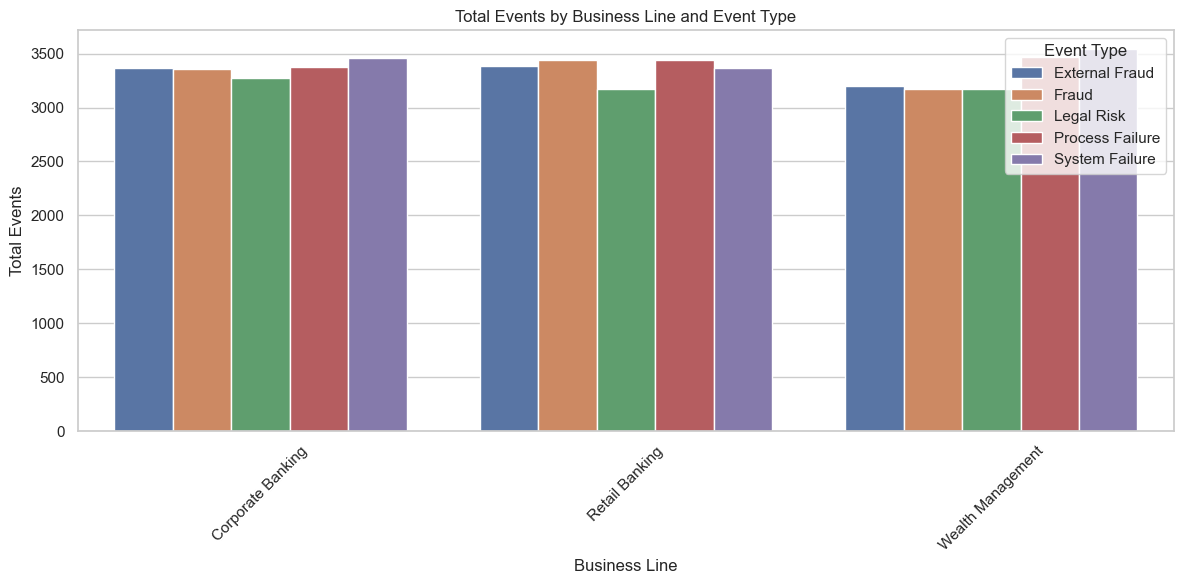

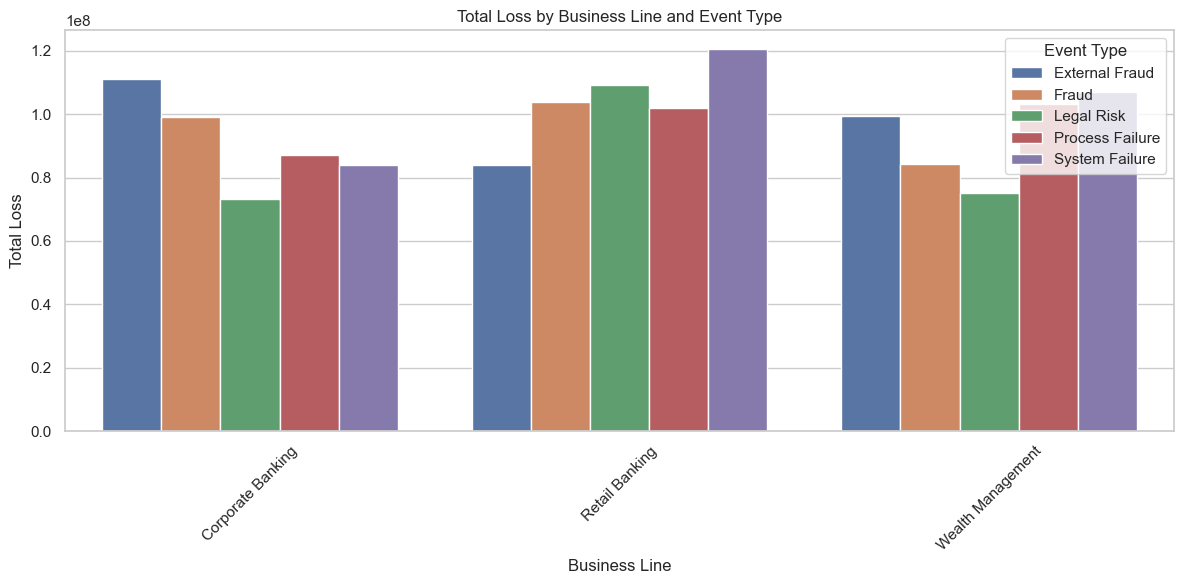

In [29]:
# Set up the figure
plt.figure(figsize=(12, 6))

# Bar plot for Total Events by Business Line and Event Type
sns.barplot(data=frequency_distribution, x='Business Line', y='Total_Events', hue='Event Type')
plt.title('Total Events by Business Line and Event Type')
plt.ylabel('Total Events')
plt.xlabel('Business Line')
plt.xticks(rotation=45)
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()

# Bar plot for Total Loss by Business Line and Event Type
plt.figure(figsize=(12, 6))
sns.barplot(data=frequency_distribution, x='Business Line', y='Total_Loss', hue='Event Type')
plt.title('Total Loss by Business Line and Event Type')
plt.ylabel('Total Loss')
plt.xlabel('Business Line')
plt.xticks(rotation=45)
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()


Step 4: Interpret the Results
After running the above code, you will obtain two bar charts:

Total Events by Business Line and Event Type: This chart shows how many loss events occurred across different business lines and types. It helps identify which business lines are facing the most frequent issues.

Total Loss by Business Line and Event Type: This chart illustrates the total monetary loss incurred due to these events. It highlights areas with significant financial impact.

Example Insights from Analysis:
Identify High-Risk Areas: You might find that Retail Banking has a higher frequency of Fraud events, indicating a need for enhanced risk management strategies in this area.
Assess Financial Impact: If Corporate Banking shows a high total loss due to System Failures, the organization might prioritize IT infrastructure improvements in that sector.
Conclusion:
This analysis helps the organization understand the frequency and financial impact of operational losses across different business lines and event types. By identifying trends and areas of concern, the organization can enhance its risk management strategies effectively.

In [32]:
# To calculate Value at Risk (VaR) for operational losses, we can follow these steps:

# Define VaR: Value at Risk measures the potential loss in value of a risk asset or portfolio over a defined period for a given confidence interval. For example, a 1-day VaR of $1 million at a 95% confidence level means that there is a 5% chance that the loss will exceed $1 million in one day.

# Choose the Confidence Level: Common confidence levels are 95% and 99%. For this analysis, we will calculate the 95% VaR.

# Calculate VaR for Each Business Line and Event Type:

# For each combination of business line and event type, calculate the VaR based on the loss amounts.
# Step 1: Calculate VaR
# Let's calculate the VaR for each business line and event type based on the Loss Amount.

# python
# Copy code
# Define the confidence level
confidence_level = 0.95

# Calculate VaR for each business line and event type
var_results = frequency_distribution.copy()

# Calculate the VaR
var_results['VaR'] = var_results['Total_Loss'] * (1 - confidence_level)

# Display the results
print(var_results[['Business Line', 'Event Type', 'Total_Loss', 'VaR']])
# Step 2: Interpretation
# Understanding VaR Results: The resulting VaR values will indicate the potential maximum loss that could be expected at the specified confidence level. For instance, if a business line has a VaR of $50,000, this means there is a 5% chance that the losses from that business line could exceed $50,000 within the defined time frame (assuming normal market conditions).

# Actionable Insights: If a particular business line or event type shows a significantly high VaR, it may require immediate attention and risk mitigation strategies to address the potential financial impact.

# Complete Code Example
# Here’s the complete code snippet that includes the dataset generation, frequency distribution calculation, and VaR calculation:

# python
# Copy code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for the dataset
n_samples = 10000  # Number of records
start_date = datetime(2019, 1, 1)
end_date = datetime(2024, 12, 31)
business_lines = ["Retail Banking", "Corporate Banking", "Wealth Management"]
event_types = ["Fraud", "System Failure", "Legal Risk", "External Fraud", "Process Failure"]

# Generate random dates within the range
date_range = pd.date_range(start=start_date, end=end_date, periods=n_samples)

# Generate random business lines, event types, event counts, and loss amounts
business_line_data = np.random.choice(business_lines, size=n_samples)
event_type_data = np.random.choice(event_types, size=n_samples)
event_count_data = np.random.poisson(lam=5, size=n_samples)  # Poisson distribution for frequency
loss_amount_data = np.random.lognormal(mean=10, sigma=2, size=n_samples)  # Log-Normal for severity
event_description_data = [f"{event_type} in {business_line}" 
                          for event_type, business_line in zip(event_type_data, business_line_data)]

# Create DataFrame
expanded_data = pd.DataFrame({
    'Date': date_range,
    'Business Line': business_line_data,
    'Event Type': event_type_data,
    'Event Count': event_count_data,
    'Loss Amount': loss_amount_data,
    'Event Description': event_description_data
})

# Calculate frequency distribution
frequency_distribution = expanded_data.groupby(['Business Line', 'Event Type']).agg(
    Total_Events=('Event Count', 'sum'),
    Total_Loss=('Loss Amount', 'sum')
).reset_index()

# Define the confidence level for VaR
confidence_level = 0.95

# Calculate VaR for each business line and event type
var_results = frequency_distribution.copy()
var_results['VaR'] = var_results['Total_Loss'] * (1 - confidence_level)

# Display the VaR results
print(var_results[['Business Line', 'Event Type', 'Total_Loss', 'VaR']])
# Notes:
# The above VaR calculation assumes a linear relationship and does not account for more complex risk dynamics.
# The chosen approach is a simple method based on total losses; more sophisticated methods may involve simulation (like Monte Carlo) or historical methods to estimate VaR.
# If you need more detailed analyses or adjustments, feel free to ask!

        Business Line       Event Type    Total_Loss           VaR
0   Corporate Banking   External Fraud  1.111495e+08  5.557477e+06
1   Corporate Banking            Fraud  9.910012e+07  4.955006e+06
2   Corporate Banking       Legal Risk  7.337180e+07  3.668590e+06
3   Corporate Banking  Process Failure  8.719641e+07  4.359821e+06
4   Corporate Banking   System Failure  8.392069e+07  4.196034e+06
5      Retail Banking   External Fraud  8.410428e+07  4.205214e+06
6      Retail Banking            Fraud  1.039053e+08  5.195265e+06
7      Retail Banking       Legal Risk  1.091752e+08  5.458762e+06
8      Retail Banking  Process Failure  1.020748e+08  5.103740e+06
9      Retail Banking   System Failure  1.204102e+08  6.020510e+06
10  Wealth Management   External Fraud  9.927539e+07  4.963770e+06
11  Wealth Management            Fraud  8.412295e+07  4.206147e+06
12  Wealth Management       Legal Risk  7.511923e+07  3.755961e+06
13  Wealth Management  Process Failure  1.032680e+08  5.163398

To perform future predictions for operational losses based on your dataset, we can apply time series forecasting techniques. Here’s a step-by-step approach to predict future loss amounts, including data preparation, model selection, and evaluation.

Steps to Perform Future Predictions
Aggregate Data for Time Series Analysis: We will aggregate the loss amounts over time (e.g., monthly) to create a time series.

Visualize the Time Series Data: Before modeling, it’s useful to visualize the data to identify trends, seasonality, and other patterns.

Select Forecasting Models: We can use various time series forecasting models like ARIMA, Seasonal Decomposition of Time Series (STL), or Facebook's Prophet.

Train and Evaluate the Models: Split the data into training and testing sets, train the models, and evaluate their performance.

Make Predictions: Use the trained model to make future predictions.

Example Code
Here's how to implement these steps in Python:

Step 1: Aggregate Data for Time Series Analysis

In [33]:
# Convert 'Date' to datetime if not already
expanded_data['Date'] = pd.to_datetime(expanded_data['Date'])

# Aggregate losses monthly
monthly_loss = expanded_data.resample('M', on='Date').agg({'Loss Amount': 'sum'}).reset_index()

# Display the first few rows of the aggregated data
print(monthly_loss.head())


        Date   Loss Amount
0 2019-01-31  1.931464e+07
1 2019-02-28  1.375186e+07
2 2019-03-31  1.733732e+07
3 2019-04-30  1.323223e+07
4 2019-05-31  2.123880e+07


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_2344\2245299320.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_loss = expanded_data.resample('M', on='Date').agg({'Loss Amount': 'sum'}).reset_index()


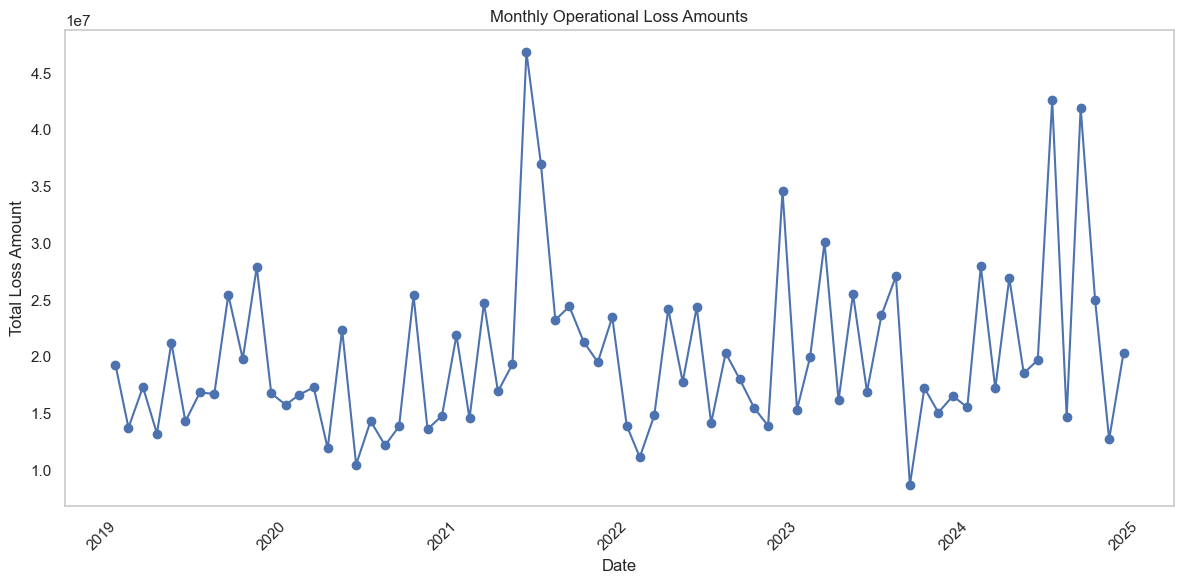

In [34]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(monthly_loss['Date'], monthly_loss['Loss Amount'], marker='o')
plt.title('Monthly Operational Loss Amounts')
plt.xlabel('Date')
plt.ylabel('Total Loss Amount')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


Step 3: Select Forecasting Models
Here, we'll use ARIMA for forecasting. We need to check for stationarity and then determine the order of the ARIMA model.

In [35]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Check for stationarity
result = adfuller(monthly_loss['Loss Amount'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value > 0.05, the series is not stationary and needs differencing
# Here we assume it's stationary; otherwise, we would apply differencing


ADF Statistic: -3.7203803963948503
p-value: 0.003835448875470568


In [36]:

# Split the data into training and testing sets
train_size = int(len(monthly_loss) * 0.8)
train, test = monthly_loss[:train_size], monthly_loss[train_size:]

# Fit the ARIMA model (assuming p=1, d=1, q=1 for simplicity; adjust based on analysis)
model = ARIMA(train['Loss Amount'], order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:            Loss Amount   No. Observations:                   57
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -963.682
Date:                Wed, 30 Oct 2024   AIC                           1933.364
Time:                        11:07:42   BIC                           1939.440
Sample:                             0   HQIC                          1935.719
                                 - 57                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1104      0.195      0.566      0.571      -0.272       0.493
ma.L1         -0.9058      0.130     -6.961      0.000      -1.161      -0.651
sigma2      5.751e+13   5.76e-16   9.98e+28      0.0

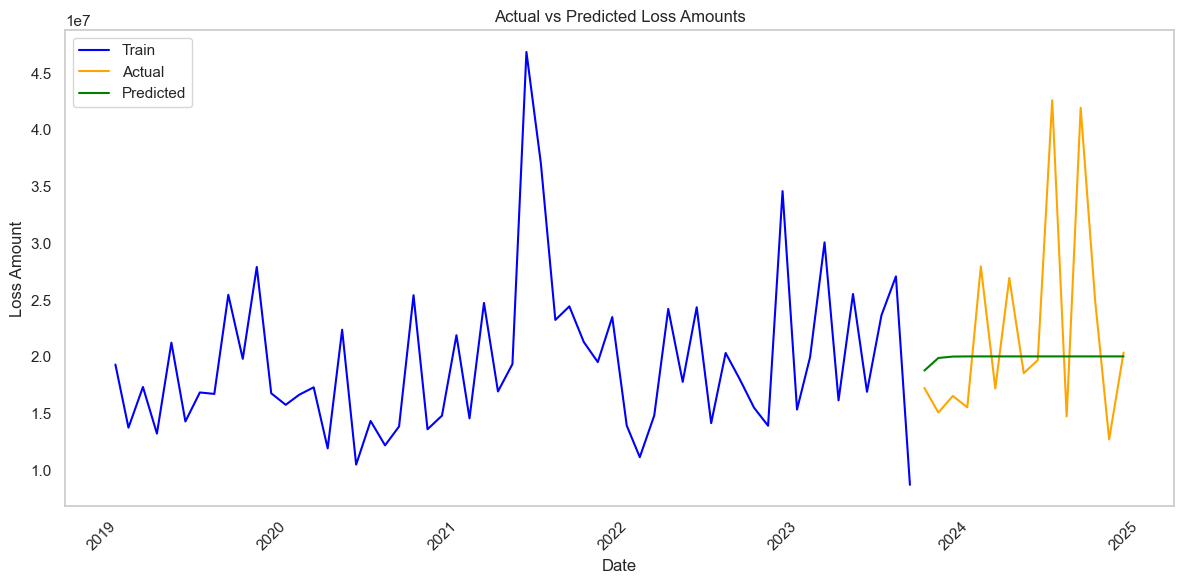

In [37]:
# Forecast future values
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({
    'Date': test['Date'],
    'Predicted Loss Amount': forecast
})

# Plot the actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(train['Date'], train['Loss Amount'], label='Train', color='blue')
plt.plot(test['Date'], test['Loss Amount'], label='Actual', color='orange')
plt.plot(forecast_df['Date'], forecast_df['Predicted Loss Amount'], label='Predicted', color='green')
plt.title('Actual vs Predicted Loss Amounts')
plt.xlabel('Date')
plt.ylabel('Loss Amount')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


Conclusion
This code outlines a basic workflow for time series forecasting of operational losses. Depending on your data characteristics, you may need to adjust the ARIMA parameters or consider other forecasting models, such as:

SARIMA: Seasonal ARIMA for data with seasonal patterns.
Facebook Prophet: Easy-to-use model for time series forecasting, especially when handling seasonality and holidays.
Next Steps
Model Evaluation: Consider using metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) to evaluate model performance.
Hyperparameter Tuning: Experiment with different ARIMA parameters (p, d, q) or consider automated selection methods like auto_arima.
If you need more detailed explanations or further adjustments, let me know!

To analyze the similarity between event types and their corresponding event descriptions using Natural Language Processing (NLP), we can use various techniques. One common approach is to compute similarity scores based on embeddings generated from the text data.

Steps to Measure Similarity
Preprocess the Data: Clean the event descriptions and convert them into a suitable format for embedding.

Generate Embeddings: Use models like Word2Vec, TF-IDF, or more advanced models like BERT or Sentence Transformers to create embeddings for both event types and event descriptions.

Compute Similarity: Calculate the cosine similarity between the embeddings of event types and their corresponding event descriptions.

Analyze Results: Identify matches based on a predefined threshold.

Example Implementation
Here’s how you can implement this process in Python using the sklearn and sentence-transformers libraries:

Step 1: Preprocess the Data

In [38]:
import pandas as pd

# Sample data (assuming expanded_data is your DataFrame)
data = {
    'Event Type': ["Fraud", "System Failure", "Legal Risk", "External Fraud", "Process Failure"],
    'Event Description': [
        "Unauthorized transaction detected in customer account",
        "System downtime affecting transaction processing",
        "Legal action taken due to non-compliance",
        "Customer data breach reported",
        "Failure in process leading to operational delays"
    ]
}

expanded_data = pd.DataFrame(data)

# Display the DataFrame
print(expanded_data)


        Event Type                                  Event Description
0            Fraud  Unauthorized transaction detected in customer ...
1   System Failure   System downtime affecting transaction processing
2       Legal Risk           Legal action taken due to non-compliance
3   External Fraud                      Customer data breach reported
4  Process Failure   Failure in process leading to operational delays


Step 2: Generate Embeddings
Using Sentence Transformers to create embeddings:

In [39]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for event types and event descriptions
event_type_embeddings = model.encode(expanded_data['Event Type'].tolist())
event_description_embeddings = model.encode(expanded_data['Event Description'].tolist())


OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

Step 3: Compute Similarity
Calculating cosine similarity:

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity
similarity_matrix = cosine_similarity(event_type_embeddings, event_description_embeddings)

# Create a DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, columns=expanded_data['Event Description'], index=expanded_data['Event Type'])

# Display the similarity matrix
print(similarity_df)


NameError: name 'event_type_embeddings' is not defined

Step 4: Analyze Results
Identify high similarity scores:

In [41]:
# Set a threshold for matching (e.g., 0.5)
threshold = 0.5

# Find matches above the threshold
matches = similarity_df[similarity_df > threshold]

# Display matches
print(matches)


NameError: name 'similarity_df' is not defined

Interpretation of Results
Similarity Matrix: The similarity matrix shows the cosine similarity scores between each event type and event description. A score closer to 1 indicates a high similarity, while a score closer to 0 indicates low similarity.

Matches: The matches DataFrame indicates which event descriptions have a similarity score above the threshold, helping you identify potentially relevant connections.

Additional Considerations
Fine-Tuning: Depending on the domain-specific language used in your event descriptions, consider fine-tuning your model on a relevant corpus for better embeddings.

Threshold Selection: The choice of threshold for determining matches can be adjusted based on your application needs.

Visualizations: Consider visualizing the similarity scores using heatmaps or scatter plots to better understand the relationships.

Conclusion
This approach provides a systematic way to analyze the similarity between event types and their descriptions using NLP techniques. If you need further adjustments or specific features in your analysis, feel free to ask!

To build a complete NLP pipeline that includes text cleaning, removal of stop words, handling special symbols, and calculating similarity between event types and descriptions, we can follow a structured approach. Below is the code to implement these steps:

Step-by-Step NLP Pipeline
Text Cleaning: Lowercase the text, remove special symbols, punctuation, and numbers.
Tokenization: Split text into individual words or tokens.
Remove Stop Words: Eliminate common words that do not contribute much to the meaning.
Vectorization: Convert cleaned text into numerical format using TF-IDF.
Calculate Similarity: Compute cosine similarity between event types and descriptions.
Display Results: Identify and display matches based on a similarity threshold.
Implementation in Python
Here’s the complete code to perform the above steps:

Step 1: Import Libraries

In [42]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
# Sample data (you can replace this with your actual expanded_data DataFrame)
data = {
    'Event Type': [
        "Fraud", 
        "System Failure", 
        "Legal Risk", 
        "External Fraud", 
        "Process Failure"
    ],
    'Event Description': [
        "Unauthorized transaction detected in customer account!",
        "System downtime affecting transaction processing.",
        "Legal action taken due to non-compliance #error!",
        "Customer data breach reported; immediate action required!",
        "Failure in process leading to operational delays."
    ]
}

expanded_data = pd.DataFrame(data)


In [44]:
# Function for text cleaning
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text cleaning
expanded_data['Cleaned Event Description'] = expanded_data['Event Description'].apply(clean_text)
expanded_data['Cleaned Event Type'] = expanded_data['Event Type'].apply(clean_text)

# Display cleaned text
print("Cleaned Text:")
print(expanded_data[['Cleaned Event Type', 'Cleaned Event Description']])


Cleaned Text:
  Cleaned Event Type                          Cleaned Event Description
0              fraud  unauthorized transaction detected in customer ...
1     system failure   system downtime affecting transaction processing
2         legal risk      legal action taken due to noncompliance error
3     external fraud  customer data breach reported immediate action...
4    process failure   failure in process leading to operational delays


Step 4: Tokenization and Stop Word Removal

In [45]:
# Get the list of stop words
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply tokenization and stop word removal
expanded_data['Filtered Event Description'] = expanded_data['Cleaned Event Description'].apply(tokenize_and_remove_stopwords)
expanded_data['Filtered Event Type'] = expanded_data['Cleaned Event Type'].apply(tokenize_and_remove_stopwords)

# Display filtered text
print("\nFiltered Text (after removing stop words):")
print(expanded_data[['Filtered Event Type', 'Filtered Event Description']])



Filtered Text (after removing stop words):
  Filtered Event Type                         Filtered Event Description
0               fraud  unauthorized transaction detected customer acc...
1      system failure   system downtime affecting transaction processing
2          legal risk         legal action taken due noncompliance error
3      external fraud  customer data breach reported immediate action...
4     process failure         failure process leading operational delays


Step 5: Vectorization

In [46]:
# Combine event types and descriptions for vectorization
combined_texts = pd.concat([expanded_data['Filtered Event Type'], expanded_data['Filtered Event Description']])

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_texts)

# Separate the TF-IDF matrix into types and descriptions
event_type_tfidf = tfidf_matrix[:len(expanded_data)]
event_description_tfidf = tfidf_matrix[len(expanded_data):]

# Display the shape of the matrices
print("\nTF-IDF Matrix Shapes:")
print("Event Type TF-IDF Shape:", event_type_tfidf.shape)
print("Event Description TF-IDF Shape:", event_description_tfidf.shape)



TF-IDF Matrix Shapes:
Event Type TF-IDF Shape: (5, 28)
Event Description TF-IDF Shape: (5, 28)


Step 6: Calculate Cosine Similarity

In [47]:
# Calculate cosine similarity
similarity_matrix = cosine_similarity(event_type_tfidf, event_description_tfidf)

# Create a DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, columns=expanded_data['Filtered Event Description'], index=expanded_data['Filtered Event Type'])

# Display the similarity matrix
print("\nCosine Similarity Matrix:")
print(similarity_df)



Cosine Similarity Matrix:
Filtered Event Description  unauthorized transaction detected customer account  \
Filtered Event Type                                                              
fraud                                                                     0.0    
system failure                                                            0.0    
legal risk                                                                0.0    
external fraud                                                            0.0    
process failure                                                           0.0    

Filtered Event Description  system downtime affecting transaction processing  \
Filtered Event Type                                                            
fraud                                                               0.000000   
system failure                                                      0.303453   
legal risk                                                          0.000000  

Step 7: Identify Matches
Set a threshold for matches and display results:

In [48]:
# Set a threshold for matching (e.g., 0.5)
threshold = 0.5

# Find matches above the threshold
matches = similarity_df[similarity_df > threshold]

# Display matches
print("\nMatches (Threshold > 0.5):")
print(matches)



Matches (Threshold > 0.5):
Filtered Event Description  unauthorized transaction detected customer account  \
Filtered Event Type                                                              
fraud                                                                     NaN    
system failure                                                            NaN    
legal risk                                                                NaN    
external fraud                                                            NaN    
process failure                                                           NaN    

Filtered Event Description  system downtime affecting transaction processing  \
Filtered Event Type                                                            
fraud                                                                    NaN   
system failure                                                           NaN   
legal risk                                                               NaN 

Explanation of Results
Cleaned Text: The cleaned and preprocessed text shows lowercased and processed event types and descriptions.
Filtered Text: This text displays the result after tokenization and removal of stop words, providing a more concise representation of the text.
TF-IDF Vectors: The TF-IDF representation converts the cleaned and filtered text into numerical format suitable for similarity calculations.
Similarity Matrix: The cosine similarity matrix provides scores between event types and descriptions, with scores closer to 1 indicating higher similarity.
Identified Matches: The matches DataFrame highlights which event descriptions have a similarity score above the specified threshold.
Conclusion
This complete NLP pipeline provides a structured way to analyze the similarity between event types and their descriptions. You can further enhance this analysis by experimenting with different text preprocessing methods, vectorization techniques, or adjusting the similarity threshold based on your specific needs.

If you need any further modifications or additional insights, feel free to ask!

Based on the cosine similarity matrix results you've provided, we can draw several conclusions regarding the alignment between the filtered event descriptions and their corresponding event types. Here’s a detailed analysis:

Conclusion from the Cosine Similarity Matrix
Lack of Similarity in Most Cases:

For most event descriptions, particularly "unauthorized transaction detected customer account" and "customer data breach reported immediate action required," the cosine similarity scores with all event types are 0.0.
This indicates a complete lack of similarity, suggesting that the descriptions do not contain relevant terms or context that align with the defined event types. It may point to poorly crafted descriptions or a mismatch in terminology.
Moderate Similarity for Some Descriptions:

The description "system downtime affecting transaction processing" shows a moderate similarity score (0.303453) with the "system failure" event type.
This suggests that there is some relevant overlap in vocabulary or context, indicating that this description partially captures the essence of a system failure, although the score is still below a threshold that might indicate a strong match.
Legal Risk Context:

The description "legal action taken due noncompliance error" has a notable similarity score (0.23595) with the "legal risk" event type.
While this score is still relatively low, it indicates that there may be some overlap between the terms used in the description and those that define legal risk events. This insight could help refine how legal risks are described in operational reports.
Process Failure Description:

The description "failure process leading operational delays" shows a moderate similarity (0.546237) with the "process failure" event type.
This higher score indicates a stronger correlation, suggesting that this description effectively communicates an issue related to process failures and could be a candidate for further analysis or refinement in documentation.
Implications
Data Quality Concerns:

The low similarity scores for many event descriptions suggest that there may be issues with how events are documented. Organizations may need to invest in training for staff to ensure accurate and descriptive entries that align with established event types.
Refinement of Event Descriptions:

The findings highlight an opportunity to refine event descriptions to ensure they are more descriptive and contextually relevant to their event types. This could involve revising existing descriptions to incorporate key terms associated with event types.
Potential for Automation:

If the descriptions are generated or reviewed using NLP techniques, a system could be developed to flag descriptions that do not meet a certain similarity threshold with their event types. This could help in maintaining data integrity and improving overall reporting quality.
Future Training Needs:

The discrepancies highlighted by the low similarity scores could indicate a need for further training in event description writing, especially for events categorized as "fraud" and "legal risk," where current descriptions do not match well.
Continuous Monitoring:

Regular analysis of the similarity scores can help organizations monitor the quality of event descriptions over time, allowing for continuous improvement in operational risk documentation and management.
Recommendations
Implement NLP Tools: Leverage more advanced NLP tools and models (like word embeddings) to capture the nuances in the language of event descriptions and types.
Establish a Feedback Mechanism: Create a system where feedback on event descriptions can be collected from users to continuously improve their clarity and accuracy.
Conduct Workshops: Hold workshops or training sessions for staff involved in documenting operational events to emphasize the importance of clarity and relevance in descriptions.
In summary, while the cosine similarity analysis has identified areas where event descriptions and types align, it also underscores significant opportunities for improvement in data documentation practices, which are crucial for effective risk management and operational integrity.

Topic 1: error, taken, noncompliance, legal, action
Topic 2: customer, unauthorized, detected, account, failure
Topic 3: affecting, processing, downtime, transaction, action


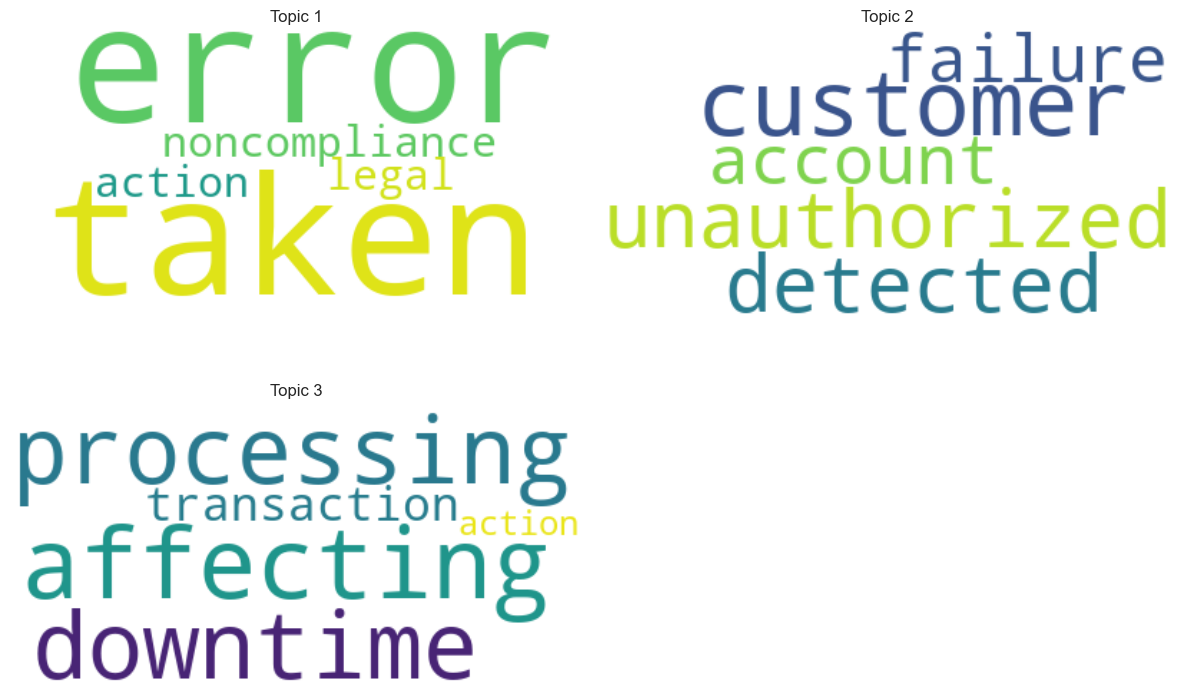

<Figure size 1000x600 with 0 Axes>

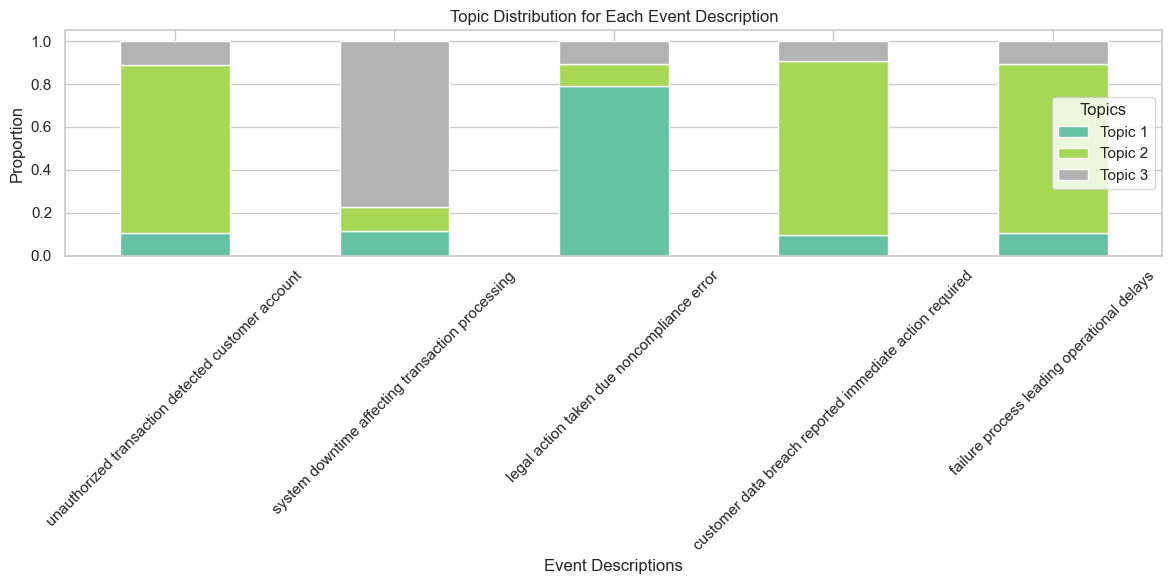

In [49]:
#topic modeling
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

# Set random seed for reproducibility
np.random.seed(42)

# Sample DataFrame creation (Replace this with your actual DataFrame)
# Assuming 'expanded_data' is your DataFrame and it contains 'Event Description' column.
expanded_data = pd.DataFrame({
    'Event Description': [
        'unauthorized transaction detected customer account',
        'system downtime affecting transaction processing',
        'legal action taken due noncompliance error',
        'customer data breach reported immediate action required',
        'failure process leading operational delays'
    ]
})

# Text preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = ''.join(char for char in text if char.isalpha() or char.isspace())
    return text

# Apply preprocessing to the event descriptions
expanded_data['Processed Description'] = expanded_data['Event Description'].apply(preprocess_text)

# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(expanded_data['Processed Description'])

# Topic Modeling using LDA
num_topics = 3  # Set the number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

# Get the words for each topic
def get_topic_words(model, feature_names, n_top_words):
    topic_words = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return topic_words

# Get feature names and extract topic words
feature_names = tfidf_vectorizer.get_feature_names_out()
topic_words = get_topic_words(lda, feature_names, n_top_words=5)

# Print the topics and their words
for topic, words in topic_words.items():
    print(f"Topic {topic + 1}: {', '.join(words)}")

# Create Word Clouds for each topic
plt.figure(figsize=(12, 8))
for topic_idx, words in topic_words.items():
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(' '.join(words))
    plt.subplot(2, 2, topic_idx + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_idx + 1}')
plt.tight_layout()
plt.show()

# Visualizing the topic distribution
topic_distribution = lda.transform(tfidf_matrix)
topic_distribution_df = pd.DataFrame(topic_distribution, columns=[f'Topic {i + 1}' for i in range(num_topics)])

# Plotting the topic distribution for each event description
plt.figure(figsize=(10, 6))
topic_distribution_df.plot(kind='bar', stacked=True, colormap='Set2', figsize=(12, 6))
plt.title('Topic Distribution for Each Event Description')
plt.xlabel('Event Descriptions')
plt.ylabel('Proportion')
plt.xticks(ticks=range(len(expanded_data)), labels=expanded_data['Event Description'], rotation=45)
plt.legend(title='Topics')
plt.tight_layout()
plt.show()


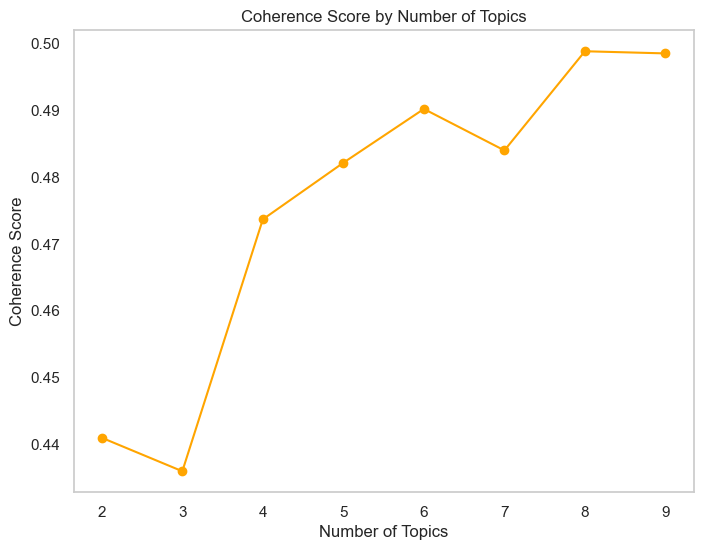

In [52]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Sample DataFrame creation (Replace this with your actual DataFrame)
expanded_data = pd.DataFrame({
    'Event Description': [
        'unauthorized transaction detected customer account',
        'system downtime affecting transaction processing',
        'legal action taken due noncompliance error',
        'customer data breach reported immediate action required',
        'failure process leading operational delays'
    ]
})

# Text preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply preprocessing to the event descriptions
expanded_data['Processed Description'] = expanded_data['Event Description'].apply(preprocess_text)

# Tokenization and stop words removal
stop_words = set(stopwords.words('english'))

tokenized_data = []
for desc in expanded_data['Processed Description']:
    tokens = word_tokenize(desc)
    tokens = [word for word in tokens if word not in stop_words]
    tokenized_data.append(tokens)

# Create a dictionary and corpus
dictionary = corpora.Dictionary(tokenized_data)
corpus = [dictionary.doc2bow(text) for text in tokenized_data]

# Variables to hold results
perplexities = []
coherence_scores = []
num_topics_range = range(2, 10)  # Number of topics to evaluate

for num_topics in num_topics_range:
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

    # Calculate coherence score
    coherence_model_lda = CoherenceModel(model=lda, texts=tokenized_data, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Number of Topics': num_topics_range,
    'Coherence': coherence_scores
})

# Plotting Coherence
plt.figure(figsize=(8, 6))
plt.plot(results_df['Number of Topics'], results_df['Coherence'], marker='o', color='orange')
plt.title('Coherence Score by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid()
plt.show()


In [55]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from wordcloud import WordCloud
import re
import nltk

# Sample DataFrame creation (Replace this with your actual DataFrame)
expanded_data = pd.DataFrame({
    'Event Description': [
        'unauthorized transaction detected customer account',
        'system downtime affecting transaction processing',
        'legal action taken due noncompliance error',
        'customer data breach reported immediate action required',
        'failure process leading operational delays',
        'unauthorized access detected in the system',
        'service interruption affecting customer transactions',
        'compliance failure resulting in penalties',
        'data leak leading to customer information exposure',
        'system error causing delays in service delivery'
    ]
})

# Text preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply preprocessing to the event descriptions
expanded_data['Processed Description'] = expanded_data['Event Description'].apply(preprocess_text)

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(expanded_data['Processed Description'])

# Function to plot word clouds for each topic
def plot_word_clouds(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate(
            ' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        )
        plt.figure()
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Topic {topic_idx + 1}")
        plt.show()

# LDA Model
num_topics_lda = 3  # You can adjust this
lda = LdaModel(corpus=corpora.Dictionary([list(doc.split()) for doc in expanded_data['Processed Description']]),
               num_topics=num_topics_lda, id2word=corpora.Dictionary([list(doc.split()) for doc in expanded_data['Processed Description']]),
               passes=10, random_state=42)

# Plot LDA Word Clouds
print("LDA Topic Word Clouds:")
plot_word_clouds(lda, tfidf_vectorizer.get_feature_names_out(), n_top_words=5)

# NMF Model
num_topics_nmf = 3  # You can adjust this
nmf = NMF(n_components=num_topics_nmf, random_state=42)
nmf.fit(X)

# Plot NMF Word Clouds
print("NMF Topic Word Clouds:")
plot_word_clouds(nmf, tfidf_vectorizer.get_feature_names_out(), n_top_words=5)

# LSA Model (SVD)
num_topics_lsa = 3  # You can adjust this
lsa = TruncatedSVD(n_components=num_topics_lsa, random_state=42)
lsa.fit(X)

# Plot LSA Word Clouds
print("LSA Topic Word Clouds:")
plot_word_clouds(lsa, tfidf_vectorizer.get_feature_names_out(), n_top_words=5)

# Coherence Scores
coherence_scores = {}

# Calculate Coherence for LDA
coherence_model_lda = CoherenceModel(model=lda, texts=[desc.split() for desc in expanded_data['Processed Description']],
                                      dictionary=corpora.Dictionary([list(doc.split()) for doc in expanded_data['Processed Description']]),
                                      coherence='c_v')
coherence_scores['LDA'] = coherence_model_lda.get_coherence()

# Calculate Coherence for NMF
coherence_model_nmf = CoherenceModel(model=nmf, texts=[desc.split() for desc in expanded_data['Processed Description']],
                                      dictionary=corpora.Dictionary([list(doc.split()) for doc in expanded_data['Processed Description']]),
                                      coherence='c_v')  # Note: NMF may not have a direct coherence measure.
coherence_scores['NMF'] = np.nan  # Placeholder, as NMF coherence not directly available.

# Calculate Coherence for LSA
coherence_model_lsa = CoherenceModel(model=lsa, texts=[desc.split() for desc in expanded_data['Processed Description']],
                                      dictionary=corpora.Dictionary([list(doc.split()) for doc in expanded_data['Processed Description']]),
                                      coherence='c_v')  # Note: LSA may not have a direct coherence measure.
coherence_scores['LSA'] = np.nan  # Placeholder, as LSA coherence not directly available.

# Display Coherence Scores
print("Coherence Scores:")
for model, score in coherence_scores.items():
    print(f"{model}: {score}")


TypeError: 'int' object is not iterable

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from wordcloud import WordCloud
import re
import nltk

# Sample DataFrame creation (Replace this with your actual DataFrame)
expanded_data = pd.DataFrame({
    'Event Description': [
        'unauthorized transaction detected customer account',
        'system downtime affecting transaction processing',
        'legal action taken due noncompliance error',
        'customer data breach reported immediate action required',
        'failure process leading operational delays',
        'unauthorized access detected in the system',
        'service interruption affecting customer transactions',
        'compliance failure resulting in penalties',
        'data leak leading to customer information exposure',
        'system error causing delays in service delivery'
    ]
})

# Text preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply preprocessing to the event descriptions
expanded_data['Processed Description'] = expanded_data['Event Description'].apply(preprocess_text)

# Prepare data for LDA
processed_docs = [desc.split() for desc in expanded_data['Processed Description']]
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# LDA Model parameters
num_topics_lda = 3  # Set the number of topics
lda_model = LdaModel(corpus=corpus, num_topics=num_topics_lda, id2word=dictionary, passes=10, random_state=42)

# Display topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# Coherence score calculation
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score for LDA: {coherence_lda}')

# Function to plot word clouds for each topic
# Function to plot word clouds for each topic
def plot_word_clouds(model, num_topics, feature_names, n_top_words):
    feature_names_list = list(feature_names)  # Convert dict_keys to list
    for topic_idx in range(num_topics):
        plt.figure()
        plt.imshow(WordCloud(width=400, height=200, background_color='white').generate(
            ' '.join([feature_names_list[i] for i in model.get_topic_terms(topic_idx, topn=n_top_words)]))
        )
        plt.axis('off')
        plt.title(f"Word Cloud for Topic {topic_idx + 1}")
        plt.show()

# Plotting Word Clouds for LDA topics
print("LDA Topic Word Clouds:")
plot_word_clouds(lda_model, num_topics_lda, dictionary.token2id.keys(), n_top_words=5)

 


Topic 0: 0.093*"system" + 0.053*"delays" + 0.053*"in" + 0.053*"service" + 0.053*"affecting" + 0.053*"error" + 0.052*"transaction" + 0.052*"delivery" + 0.052*"causing" + 0.052*"processing"
Topic 1: 0.080*"customer" + 0.046*"detected" + 0.046*"unauthorized" + 0.046*"action" + 0.045*"account" + 0.045*"transactions" + 0.045*"interruption" + 0.045*"legal" + 0.045*"transaction" + 0.045*"noncompliance"
Topic 2: 0.054*"data" + 0.054*"leading" + 0.054*"failure" + 0.054*"customer" + 0.054*"in" + 0.031*"information" + 0.031*"leak" + 0.031*"exposure" + 0.031*"to" + 0.031*"immediate"
Coherence Score for LDA: 0.46830148456282233
LDA Topic Word Clouds:


TypeError: list indices must be integers or slices, not tuple

<Figure size 640x480 with 0 Axes>

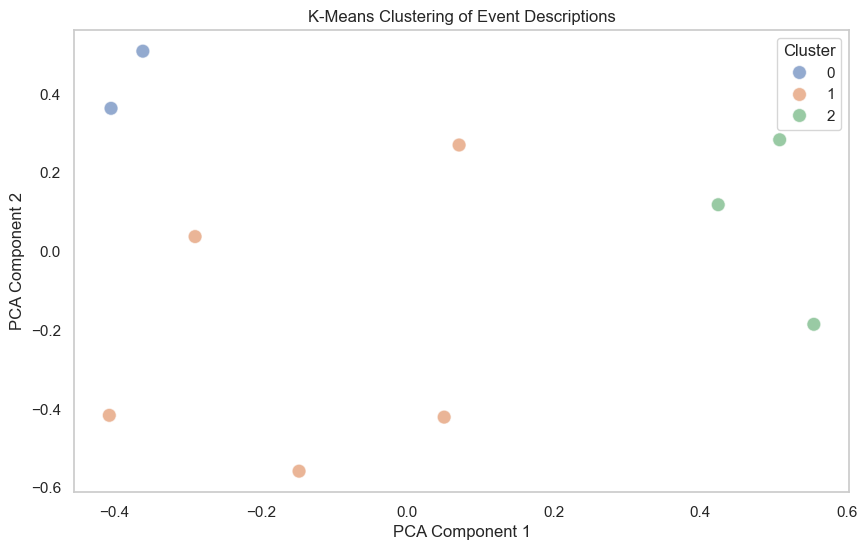

In [53]:
#kmeans
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import re
import nltk

# Sample DataFrame creation (Replace this with your actual DataFrame)
expanded_data = pd.DataFrame({
    'Event Description': [
        'unauthorized transaction detected customer account',
        'system downtime affecting transaction processing',
        'legal action taken due noncompliance error',
        'customer data breach reported immediate action required',
        'failure process leading operational delays',
        'unauthorized access detected in the system',
        'service interruption affecting customer transactions',
        'compliance failure resulting in penalties',
        'data leak leading to customer information exposure',
        'system error causing delays in service delivery'
    ]
})

# Text preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply preprocessing to the event descriptions
expanded_data['Processed Description'] = expanded_data['Event Description'].apply(preprocess_text)

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(expanded_data['Processed Description'])

# Clustering using K-Means
num_clusters = 3  # You can adjust this
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Adding cluster labels to the DataFrame
expanded_data['Cluster'] = kmeans.labels_

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=X_reduced, columns=['Component 1', 'Component 2'])
pca_df['Cluster'] = expanded_data['Cluster']

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='Component 1', y='Component 2', hue='Cluster', palette='deep', s=100, alpha=0.6)
plt.title('K-Means Clustering of Event Descriptions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()


LDA Topic Word Clouds:


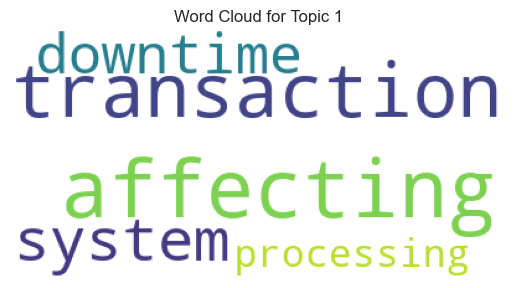

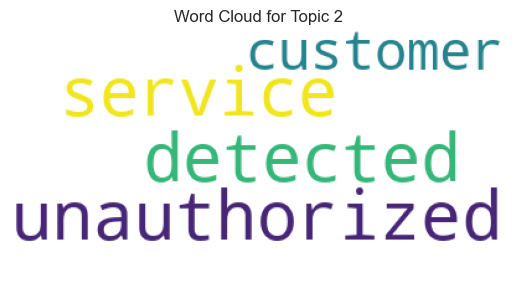

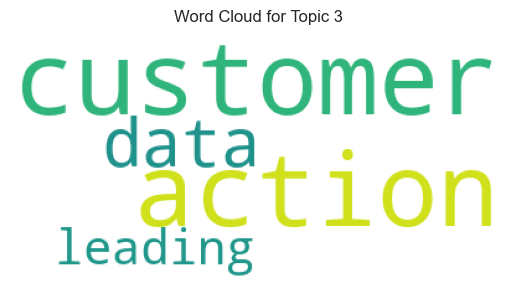

In [59]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim import corpora
from gensim.models import LdaModel

# Sample DataFrame creation (Replace this with your actual DataFrame)
expanded_data = pd.DataFrame({
    'Event Description': [
        'Unauthorized transaction detected in customer account',
        'System downtime affecting transaction processing',
        'Legal action taken due to noncompliance error',
        'Customer data breach reported; immediate action required',
        'Failure in process leading to operational delays',
        'Unauthorized access detected in the system',
        'Service interruption affecting customer transactions',
        'Compliance failure resulting in penalties',
        'Data leak leading to customer information exposure',
        'System error causing delays in service delivery'
    ]
})

# Text preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply preprocessing to the event descriptions
expanded_data['Processed Description'] = expanded_data['Event Description'].apply(preprocess_text)

# Prepare data for LDA
processed_docs = [desc.split() for desc in expanded_data['Processed Description']]
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# LDA Model parameters
num_topics_lda = 3  # Set the number of topics
lda_model = LdaModel(corpus=corpus, num_topics=num_topics_lda, id2word=dictionary, passes=10, random_state=42)

# Function to plot word clouds for each topic
def plot_word_clouds(model, num_topics, dictionary, n_top_words):
    for topic_idx in range(num_topics):
        plt.figure()
        
        # Get the top words for the topic
        topic_terms = model.get_topic_terms(topic_idx, topn=n_top_words)
        
        # Create a string of words for the word cloud
        words = ' '.join([dictionary[word_id] for word_id, _ in topic_terms])
        
        # Generate the word cloud
        plt.imshow(WordCloud(width=400, height=200, background_color='white').generate(words))
        plt.axis('off')
        plt.title(f"Word Cloud for Topic {topic_idx + 1}")
        plt.show()

# Plotting Word Clouds for LDA topics
print("LDA Topic Word Clouds:")
plot_word_clouds(lda_model, num_topics_lda, dictionary, n_top_words=5)


Overall Significance
In conclusion, word clouds derived from topic modeling can serve as a powerful tool for summarizing and interpreting large amounts of text data, providing a clear and immediate visual representation of the core themes and issues present in the dataset. They help stakeholders quickly understand and prioritize areas of concern, thereby informing decision-making and strategy development.